## A notebook to create a bar graph of CTs inside AS

## Install and import libraries

In [379]:
%pip install pandas seaborn numpy requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import requests
from  io import StringIO

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load data

In [380]:
url = "https://grlc.io/api-git/hubmapconsortium/ccf-grlc/subdir/hra-pop/cell_types_in_anatomical_structurescts_per_as"

headers = {
  'Accept' :'text/csv'
  }

data = requests.get(url=url, headers=headers).text
df = pd.read_csv(StringIO(data))

df

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage
0,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_smc-plpp2-,SMC (PLPP2+),92.848,0.114140
1,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_cycling-plasma...,Cycling plasma cell,63.448,0.077998
2,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_mesoderm-1-hand1-,Mesoderm 1 (HAND1+),57.400,0.070563
3,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_colonocyte,Colonocyte,53.928,0.066295
4,large intestine,http://purl.obolibrary.org/obo/UBERON_0001153,caecum,Female,celltypist,sc_transcriptomics,https://purl.org/ccf/ASCTB-TEMP_goblet-cell,Goblet cell,49.280,0.060581
...,...,...,...,...,...,...,...,...,...,...
7846,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_mast-cell,Mast Cell,15322.464,0.024702
7847,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_cd8-t-cell,CD8+ T Cell,3691.176,0.005951
7848,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_lymphatic-endo...,Lymphatic Endothelial (and some immune cells),1753.956,0.002828
7849,lung,http://purl.org/sig/ont/fma/fma7508,Left posterior basal segmental bronchus,Male,sc_proteomics,sc_proteomics,https://purl.org/ccf/ASCTB-TEMP_basal-epitheli...,Basal Epithelial Cell,970.104,0.001564


## Global settings

In [381]:
hra_pop_version = 'v0.11.1'

output_folder = 'output/ctBar3dAs'

# adjust vis
# plt.rcParams['figure.figsize'] = (10, 2.5)

# Set global font sizes using rcParams
plt.rcParams.update({
    "axes.titlesize": 20,    # Font size for plot titles
    "axes.labelsize": 13,    # Font size for x and y labels
    "xtick.labelsize": 12,   # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
    "legend.fontsize": 13,
    "legend.title_fontsize": 15
})

## Preprocess

In [382]:
# filter by tool (azimuth, then celltypist, then popv)
# Function to determine if a row should be kept based on conditions
def filter_rows(df):
    # Step 1: Group by `sex`, `as_label`, and `modality`
    groups = df.groupby(['organ','sex', 'as_label', 'modality'])

    # Step 2: Initialize a list to store the rows to keep
    rows_to_keep = []

    # Step 3: Loop through each group
    for _, group in groups:
        # If 'sc_proteomics' exists in the group, always those rows but do not discard others
        if 'sc_proteomics' in group['tool'].values:
          rows_to_keep.append(group[group['tool'] == 'sc_proteomics'])
      
        # If 'azimuth' exists in the group, keep only those rows
        if 'azimuth' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'azimuth'])
        # If no 'azimuth' but 'cell_typist' exists, keep 'cell_typist'
        elif 'celltypist' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'celltypist'])
        # If neither 'azimuth' nor 'cell_typist' exist, keep 'popv'
        elif 'popv' in group['tool'].values:
            rows_to_keep.append(group[group['tool'] == 'popv'])

    # Combine all the rows to keep
    df_filtered = pd.concat(rows_to_keep)
    return df_filtered


# Apply the filtering function
df_filtered = filter_rows(df)

# Display the filtered DataFrame
df_filtered

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage
2057,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_4030022,Medullary Fibroblast,1832.421,0.274784
2059,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000718,Inner Medullary Collecting Duct,1146.533,0.171930
2061,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000692,Fibroblast,876.037,0.131368
2063,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000597,Papillary Tip Epithelial,749.843,0.112444
2065,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000768,Connecting Tubule,315.994,0.047385
...,...,...,...,...,...,...,...,...,...,...
4237,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000814,mature NK T cell,53.168,0.001612
4238,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002138,endothelial cell of lymphatic vessel,52.639,0.001596
4239,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B cell,20.586,0.000624
4240,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000084,T cell,10.935,0.000332


In [383]:
# get unique combinations of organ, sex, AS, tool, and modality
unique_combinations = df_filtered[['organ','sex', 'as_label','tool', 'modality']].drop_duplicates().reset_index().drop(columns=['index'])
unique_combinations

,organ,sex,as_label,tool,modality
0,Left kidney,Female,hilum of kidney,azimuth,sc_transcriptomics
1,Left kidney,Female,kidney capsule,azimuth,sc_transcriptomics
2,Left kidney,Female,outer cortex of kidney,azimuth,sc_transcriptomics
3,Left kidney,Female,renal column,azimuth,sc_transcriptomics
4,Left kidney,Female,renal papilla,azimuth,sc_transcriptomics
...,...,...,...,...,...
122,spleen,Male,hilum of spleen,popv,sc_transcriptomics
123,spleen,Male,renal surface of spleen,sc_proteomics,sc_proteomics
124,urinary bladder,Female,fundus of urinary bladder,popv,sc_transcriptomics
125,urinary bladder,Male,fundus of urinary bladder,popv,sc_transcriptomics


## Visualize

In [384]:
def build_grouped_bar_graph(df:pd.DataFrame, organ:str, sex:str, anatomical_structure_label:str, modality:str, tool:str):
  """Makes a grouped bar graph given the sex

  Args:
      df (pd.DataFrame): df with all data
      sex (str): needed sex
  """
  
  # check matches
  has_organ = df['organ'] == organ
  has_sex = df['sex'].str.lower() == sex.lower()
  has_as = df['as_label'] == anatomical_structure_label
  has_modality = df['modality'] == modality
  has_tool = df['tool'] == tool
  
  # sort
  df_sorted = df[has_organ & has_sex & has_as & has_modality & has_tool].sort_values(by=['cell_percentage'], ascending=False)
  
  # get top cell types
  top_n_cell_types = df_sorted['cell_label'].unique()[:5]
  df_top_n = df_sorted[df_sorted['cell_label'].isin(top_n_cell_types)]
  
  # plot
  g = sns.barplot(
      data=df_top_n,
    x='cell_percentage',
    y='cell_label',
    dodge=False,
    errorbar=None,
    width=0.05, # very thin bars
  )
  
  # customize labels
  plt.xlabel('Percentage')
  plt.ylabel('Cell Type')
  plt.title('')
  
  # size and layout
  plt.figure(figsize=(10, 2))  # Taller plot = less vertical crowding
  plt.tight_layout()
  
  # Save the plot as a PNG with 300 DPI
  g.figure.savefig(f'{output_folder}/{sex}_{anatomical_structure_label}_{tool}.png', dpi=300, bbox_inches='tight')

  # display plot
  print(f'{organ}, {sex}, {anatomical_structure_label}, {modality}, {tool}')
  plt.show()

values: Left kidney, Female, hilum of kidney, sc_transcriptomics, azimuth
Left kidney, Female, hilum of kidney, sc_transcriptomics, azimuth


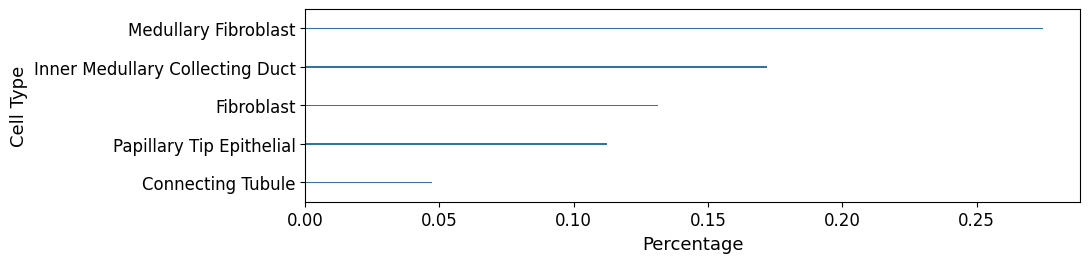

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Female, kidney capsule, sc_transcriptomics, azimuth
Left kidney, Female, kidney capsule, sc_transcriptomics, azimuth


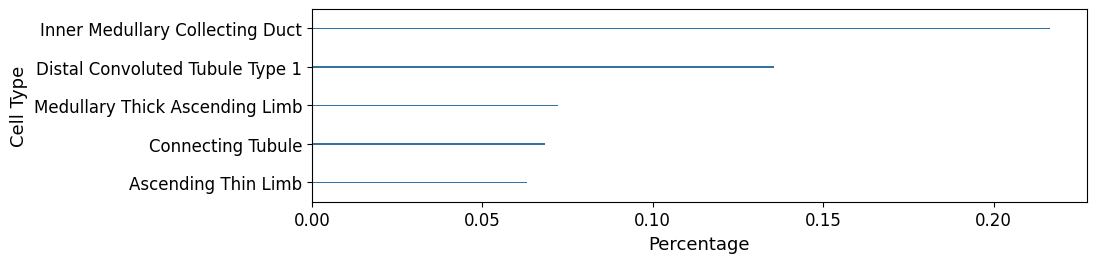

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Female, outer cortex of kidney, sc_transcriptomics, azimuth
Left kidney, Female, outer cortex of kidney, sc_transcriptomics, azimuth


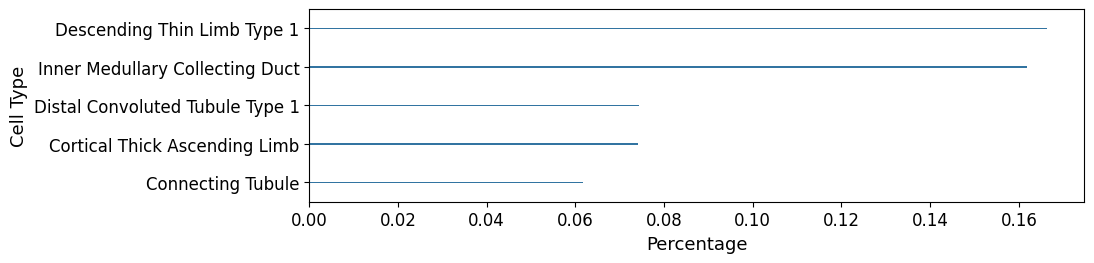

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Female, renal column, sc_transcriptomics, azimuth
Left kidney, Female, renal column, sc_transcriptomics, azimuth


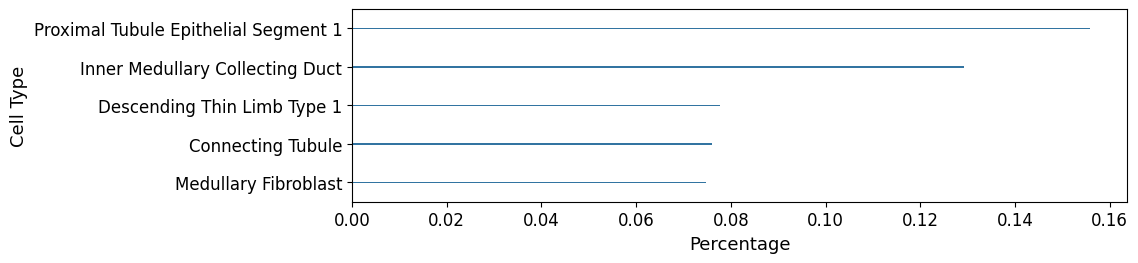

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Female, renal papilla, sc_transcriptomics, azimuth
Left kidney, Female, renal papilla, sc_transcriptomics, azimuth


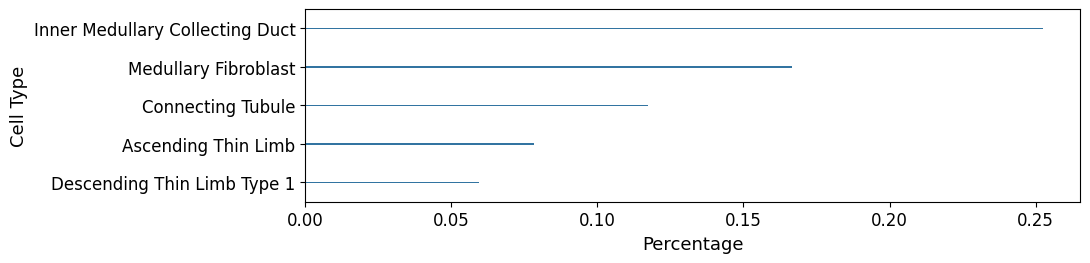

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Female, renal pyramid, sc_transcriptomics, azimuth
Left kidney, Female, renal pyramid, sc_transcriptomics, azimuth


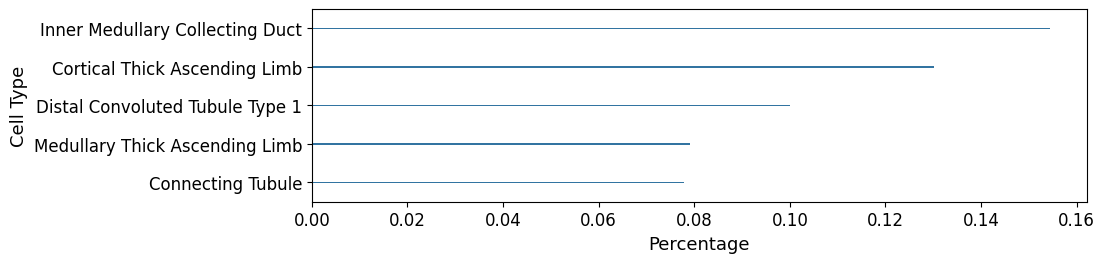

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Male, hilum of kidney, sc_transcriptomics, azimuth
Left kidney, Male, hilum of kidney, sc_transcriptomics, azimuth


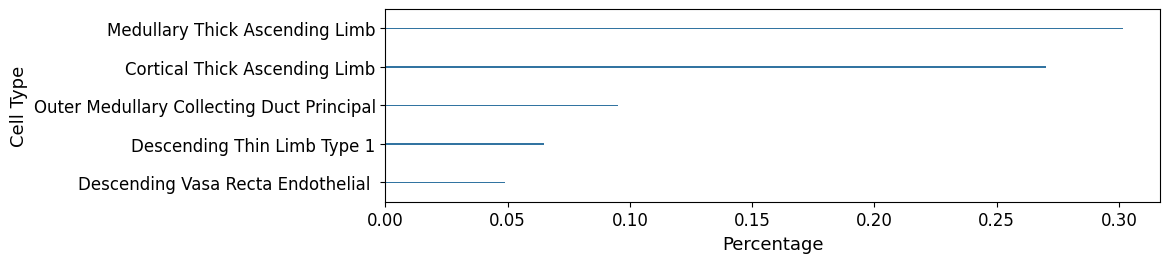

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Male, kidney capsule, sc_transcriptomics, azimuth
Left kidney, Male, kidney capsule, sc_transcriptomics, azimuth


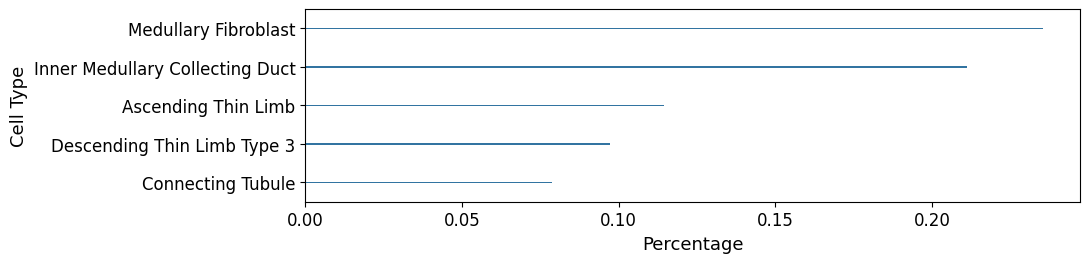

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Male, outer cortex of kidney, sc_transcriptomics, azimuth
Left kidney, Male, outer cortex of kidney, sc_transcriptomics, azimuth


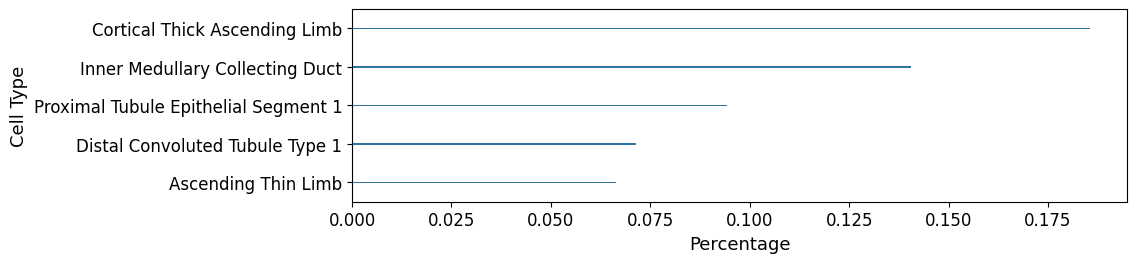

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Male, renal column, sc_transcriptomics, azimuth
Left kidney, Male, renal column, sc_transcriptomics, azimuth


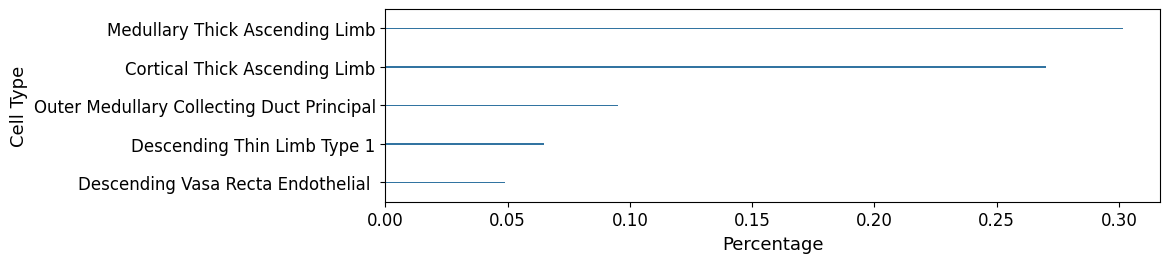

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Male, renal papilla, sc_transcriptomics, azimuth
Left kidney, Male, renal papilla, sc_transcriptomics, azimuth


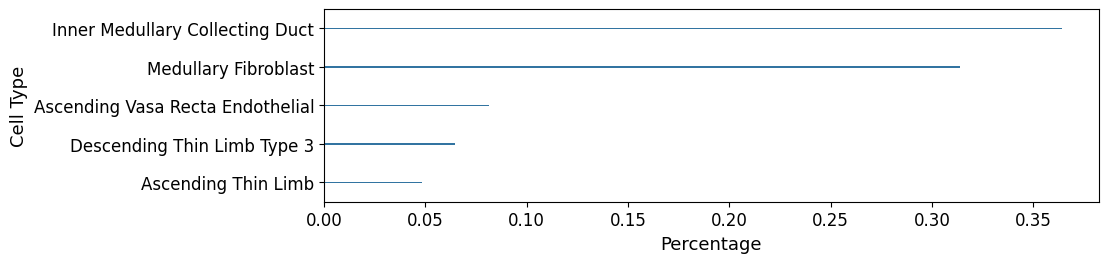

<Figure size 1000x200 with 0 Axes>

values: Left kidney, Male, renal pyramid, sc_transcriptomics, azimuth
Left kidney, Male, renal pyramid, sc_transcriptomics, azimuth


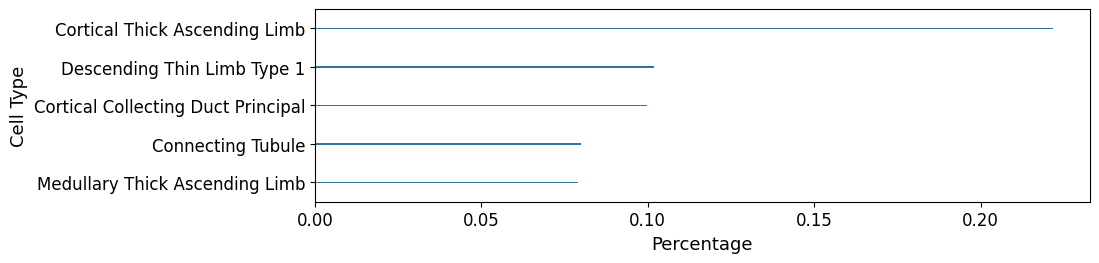

<Figure size 1000x200 with 0 Axes>

values: Left mammary gland, Female, main lactiferous duct, sc_transcriptomics, popv
Left mammary gland, Female, main lactiferous duct, sc_transcriptomics, popv


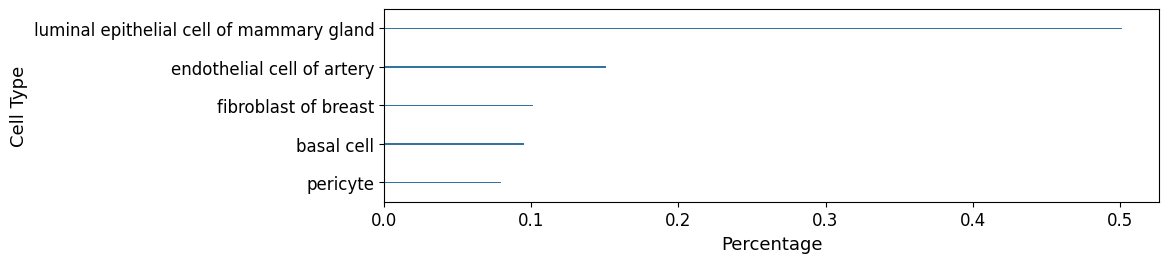

<Figure size 1000x200 with 0 Axes>

values: Left ureter, Female, Left ureter, sc_transcriptomics, azimuth
Left ureter, Female, Left ureter, sc_transcriptomics, azimuth


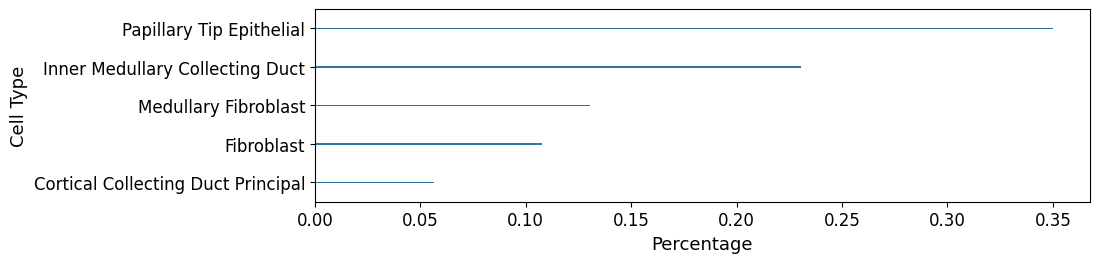

<Figure size 1000x200 with 0 Axes>

values: Left ureter, Male, Left ureter, sc_transcriptomics, azimuth
Left ureter, Male, Left ureter, sc_transcriptomics, azimuth


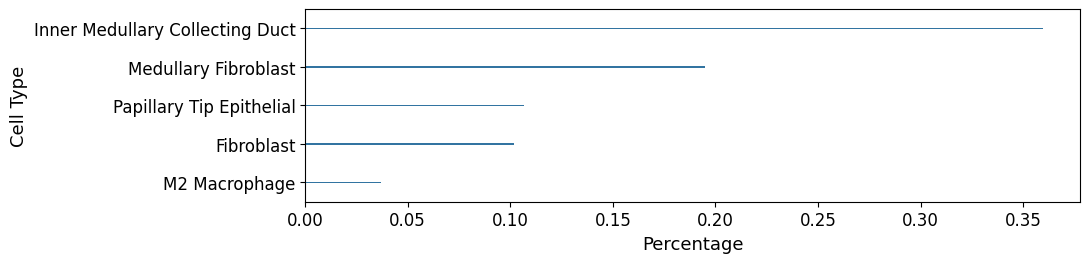

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Female, hilum of kidney, sc_transcriptomics, azimuth
Right kidney, Female, hilum of kidney, sc_transcriptomics, azimuth


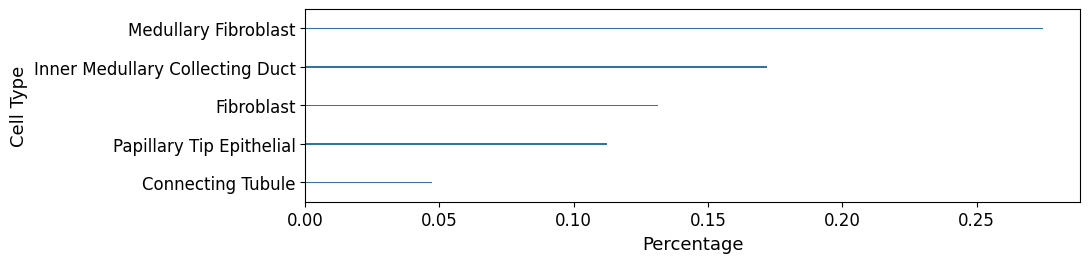

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Female, kidney capsule, sc_transcriptomics, azimuth
Right kidney, Female, kidney capsule, sc_transcriptomics, azimuth


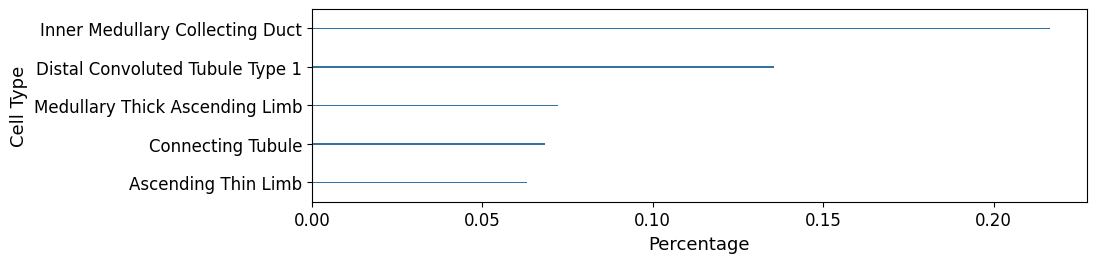

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Female, outer cortex of kidney, sc_transcriptomics, azimuth
Right kidney, Female, outer cortex of kidney, sc_transcriptomics, azimuth


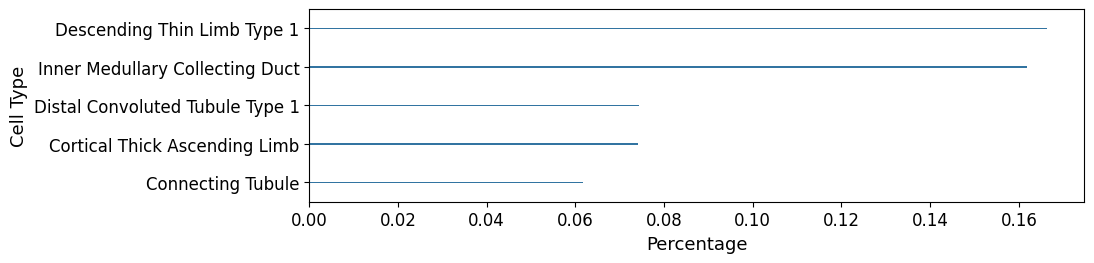

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Female, renal column, sc_transcriptomics, azimuth
Right kidney, Female, renal column, sc_transcriptomics, azimuth


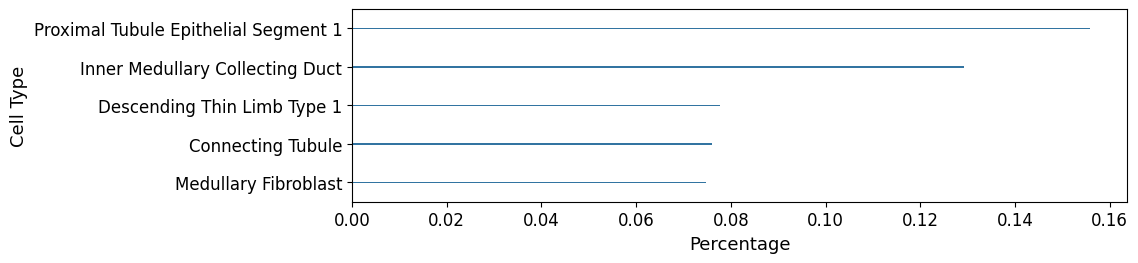

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Female, renal papilla, sc_transcriptomics, azimuth
Right kidney, Female, renal papilla, sc_transcriptomics, azimuth


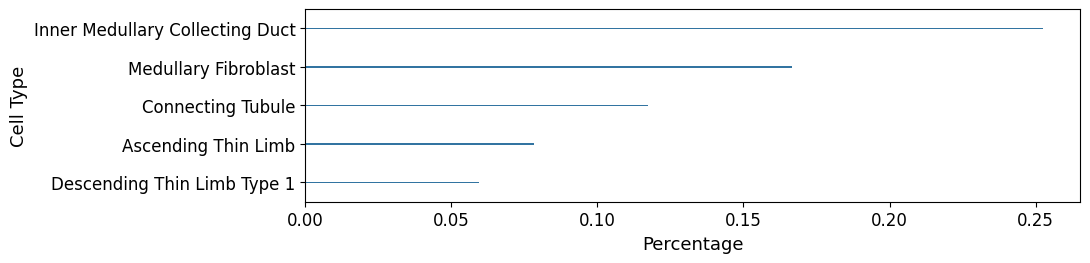

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Female, renal pyramid, sc_transcriptomics, azimuth
Right kidney, Female, renal pyramid, sc_transcriptomics, azimuth


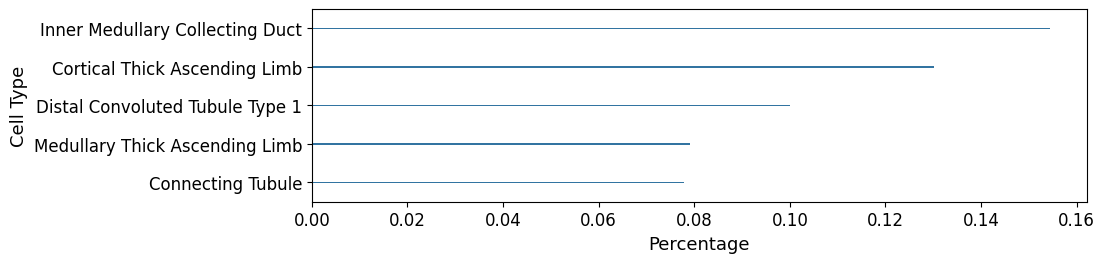

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Male, hilum of kidney, sc_transcriptomics, azimuth
Right kidney, Male, hilum of kidney, sc_transcriptomics, azimuth


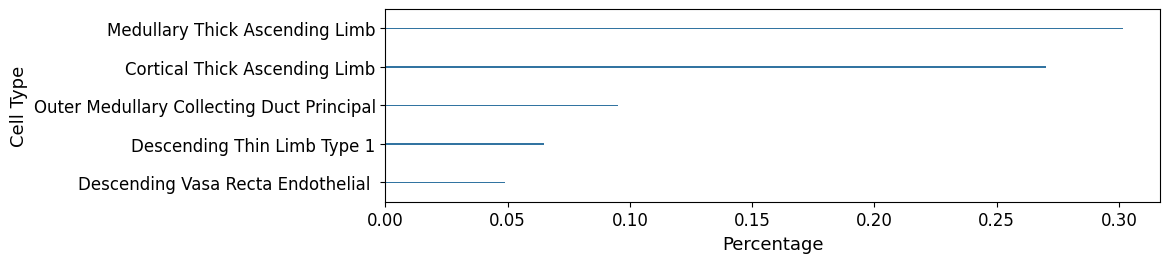

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Male, kidney capsule, sc_transcriptomics, azimuth
Right kidney, Male, kidney capsule, sc_transcriptomics, azimuth


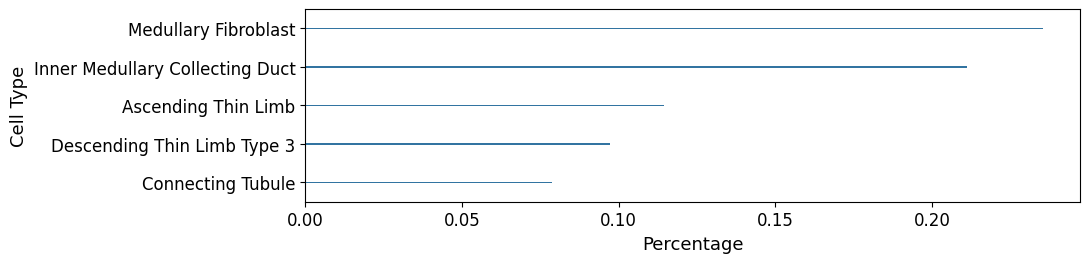

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Male, outer cortex of kidney, sc_transcriptomics, azimuth
Right kidney, Male, outer cortex of kidney, sc_transcriptomics, azimuth


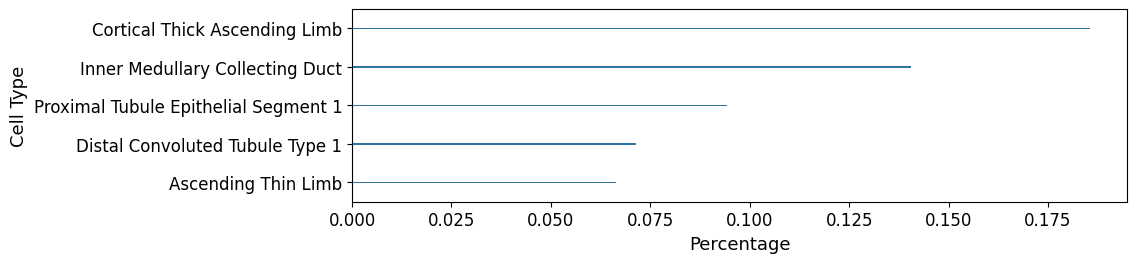

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Male, renal column, sc_transcriptomics, azimuth
Right kidney, Male, renal column, sc_transcriptomics, azimuth


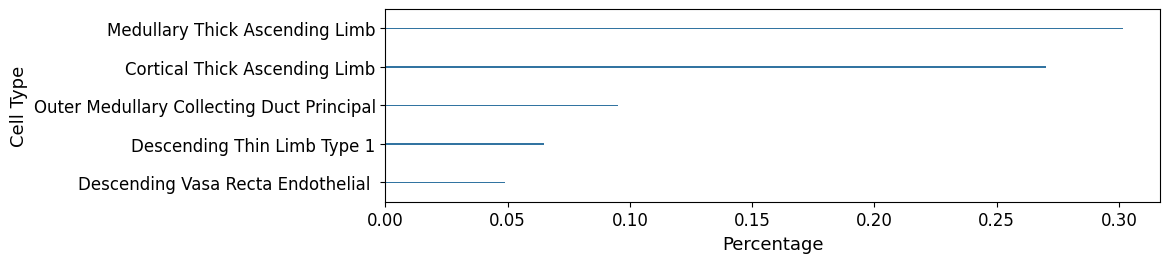

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Male, renal papilla, sc_transcriptomics, azimuth
Right kidney, Male, renal papilla, sc_transcriptomics, azimuth


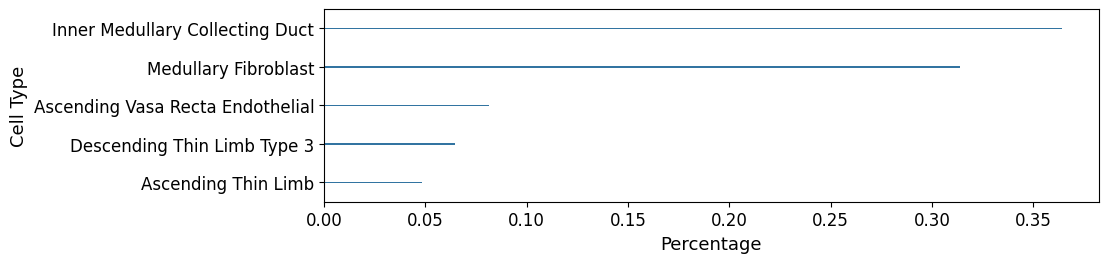

<Figure size 1000x200 with 0 Axes>

values: Right kidney, Male, renal pyramid, sc_transcriptomics, azimuth
Right kidney, Male, renal pyramid, sc_transcriptomics, azimuth


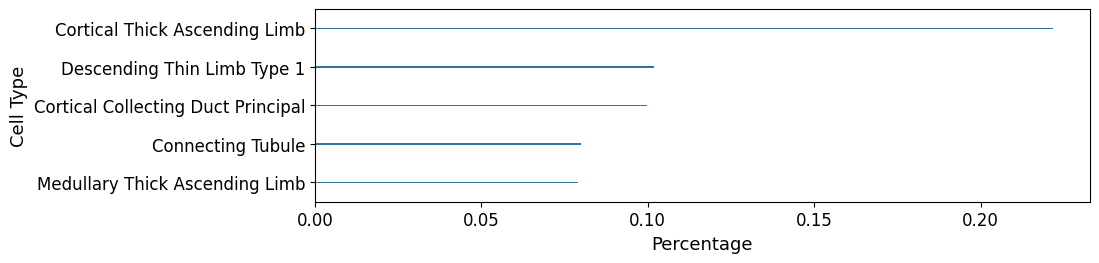

<Figure size 1000x200 with 0 Axes>

values: Right mammary gland, Female, Interlobar adipose tissue of right mammary gland, sc_transcriptomics, popv
Right mammary gland, Female, Interlobar adipose tissue of right mammary gland, sc_transcriptomics, popv


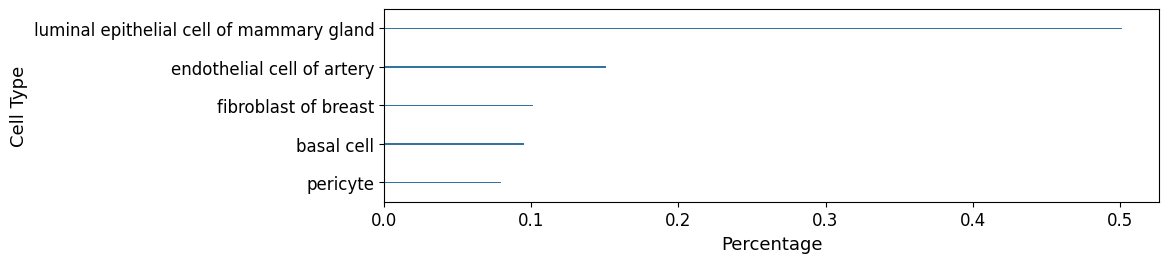

<Figure size 1000x200 with 0 Axes>

values: Right mammary gland, Female, main lactiferous duct, sc_transcriptomics, popv
Right mammary gland, Female, main lactiferous duct, sc_transcriptomics, popv


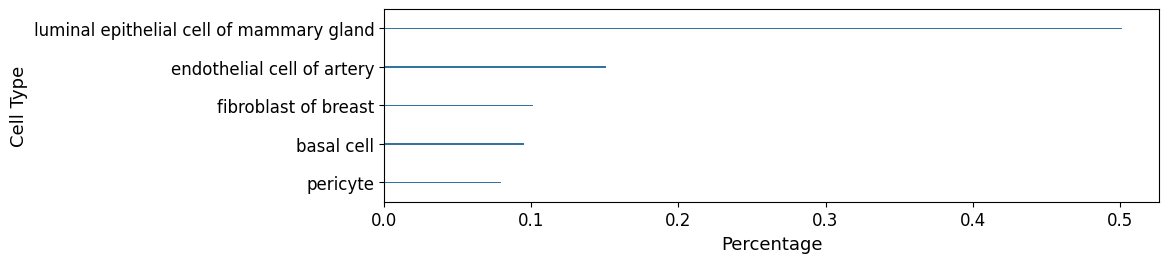

<Figure size 1000x200 with 0 Axes>

values: Right ureter, Female, Right ureter, sc_transcriptomics, azimuth
Right ureter, Female, Right ureter, sc_transcriptomics, azimuth


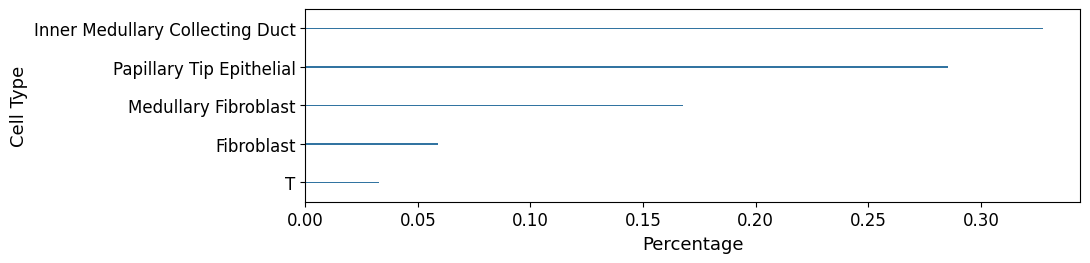

<Figure size 1000x200 with 0 Axes>

values: Right ureter, Male, Right ureter, sc_transcriptomics, azimuth
Right ureter, Male, Right ureter, sc_transcriptomics, azimuth


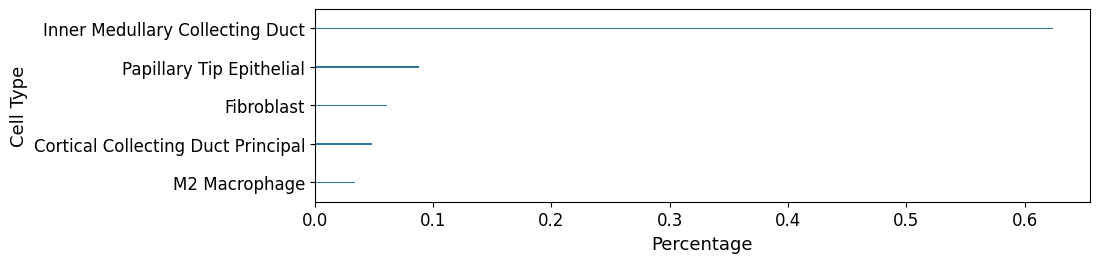

<Figure size 1000x200 with 0 Axes>

values: heart, Female, Posteromedial head of posterior papillary muscle of left ventricle, sc_transcriptomics, azimuth
heart, Female, Posteromedial head of posterior papillary muscle of left ventricle, sc_transcriptomics, azimuth


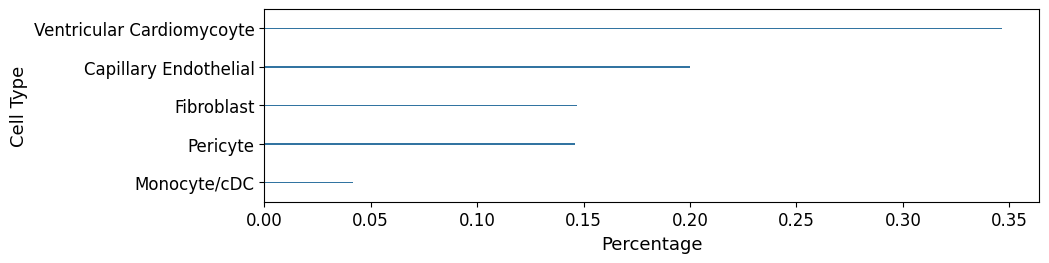

<Figure size 1000x200 with 0 Axes>

values: heart, Female, heart left ventricle, sc_transcriptomics, azimuth
heart, Female, heart left ventricle, sc_transcriptomics, azimuth


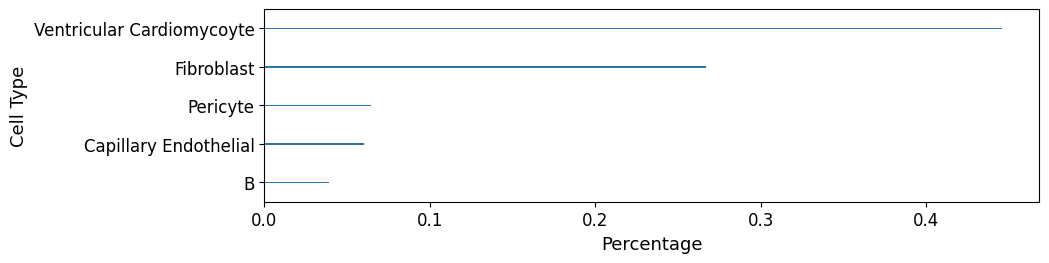

<Figure size 1000x200 with 0 Axes>

values: heart, Female, heart right ventricle, sc_transcriptomics, azimuth
heart, Female, heart right ventricle, sc_transcriptomics, azimuth


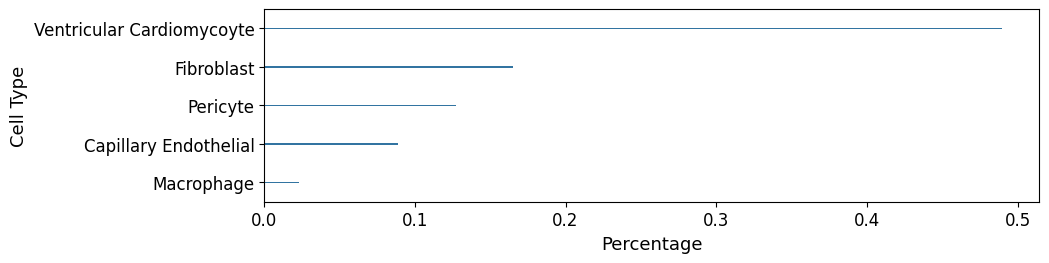

<Figure size 1000x200 with 0 Axes>

values: heart, Female, interventricular septum, sc_transcriptomics, azimuth
heart, Female, interventricular septum, sc_transcriptomics, azimuth


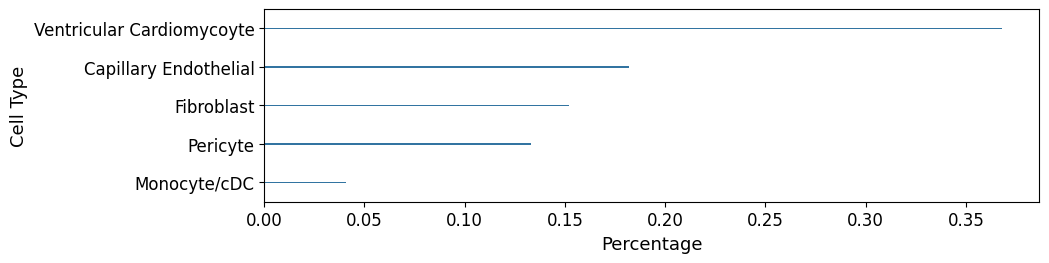

<Figure size 1000x200 with 0 Axes>

values: heart, Female, left cardiac atrium, sc_transcriptomics, azimuth
heart, Female, left cardiac atrium, sc_transcriptomics, azimuth


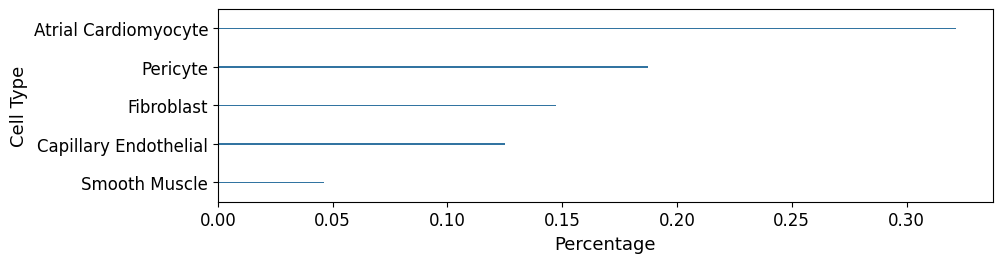

<Figure size 1000x200 with 0 Axes>

values: heart, Female, right cardiac atrium, sc_transcriptomics, azimuth
heart, Female, right cardiac atrium, sc_transcriptomics, azimuth


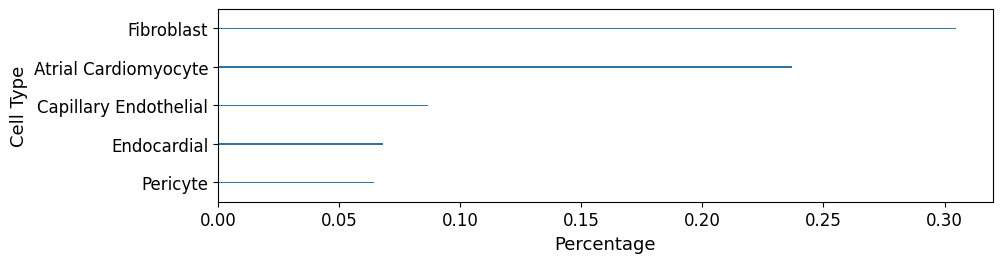

<Figure size 1000x200 with 0 Axes>

values: heart, Male, heart left ventricle, sc_transcriptomics, azimuth
heart, Male, heart left ventricle, sc_transcriptomics, azimuth


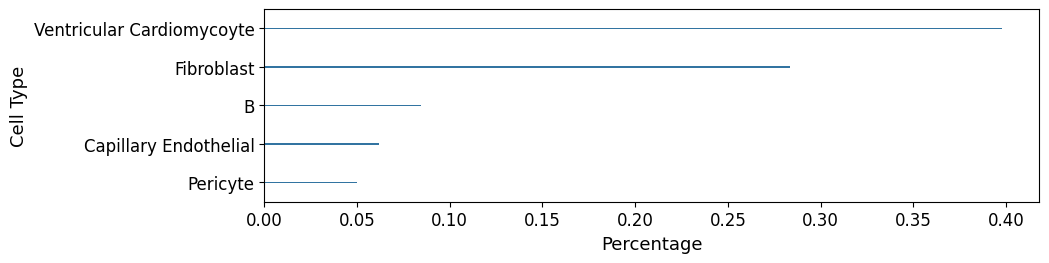

<Figure size 1000x200 with 0 Axes>

values: heart, Male, heart right ventricle, sc_transcriptomics, azimuth
heart, Male, heart right ventricle, sc_transcriptomics, azimuth


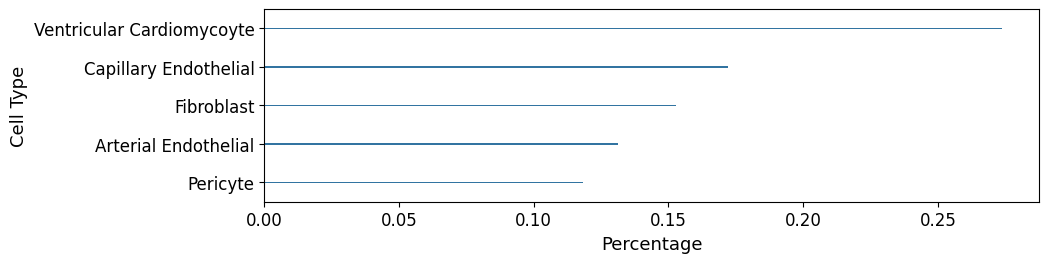

<Figure size 1000x200 with 0 Axes>

values: heart, Male, interventricular septum, sc_transcriptomics, azimuth
heart, Male, interventricular septum, sc_transcriptomics, azimuth


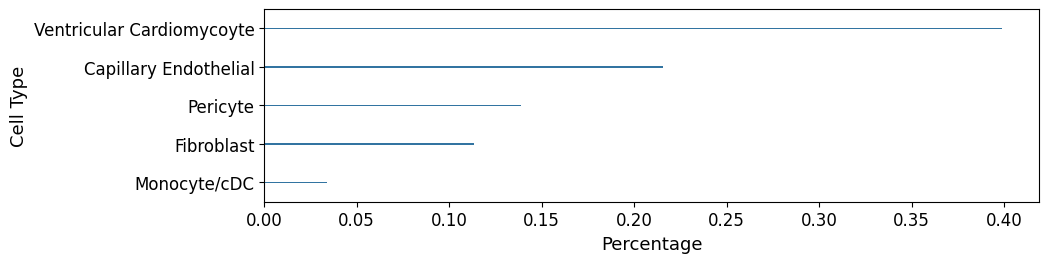

<Figure size 1000x200 with 0 Axes>

values: heart, Male, left cardiac atrium, sc_transcriptomics, azimuth
heart, Male, left cardiac atrium, sc_transcriptomics, azimuth


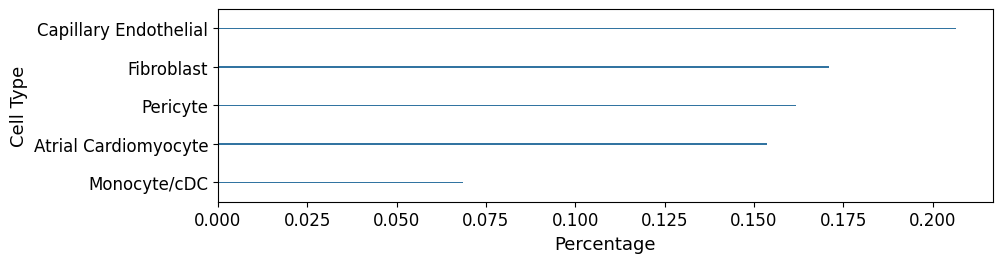

<Figure size 1000x200 with 0 Axes>

values: heart, Male, right cardiac atrium, sc_transcriptomics, azimuth
heart, Male, right cardiac atrium, sc_transcriptomics, azimuth


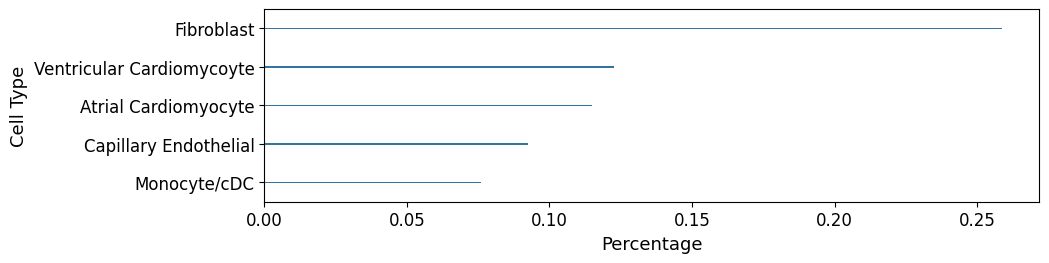

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, ascending colon, sc_proteomics, sc_proteomics
large intestine, Female, ascending colon, sc_proteomics, sc_proteomics


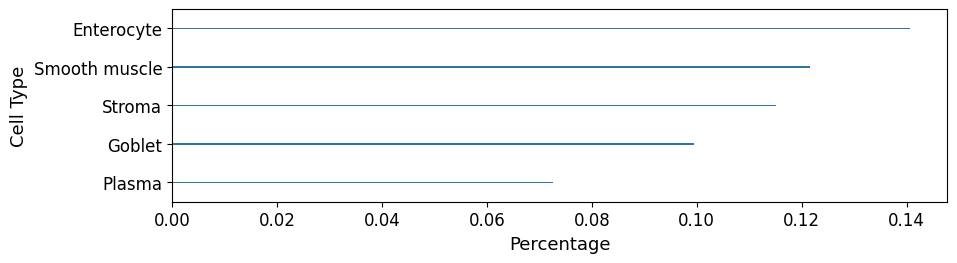

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, ascending colon, sc_transcriptomics, celltypist
large intestine, Female, ascending colon, sc_transcriptomics, celltypist


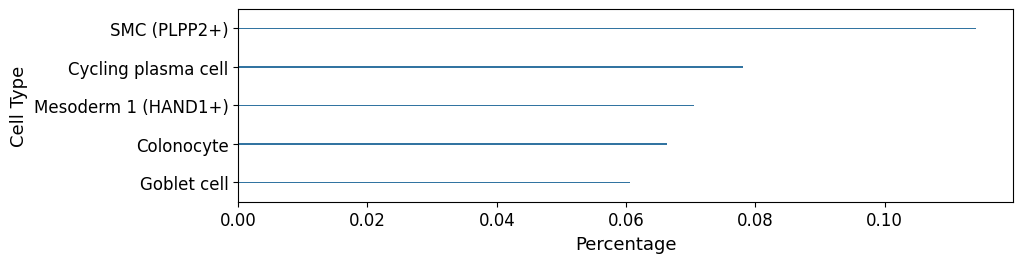

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, caecum, sc_proteomics, sc_proteomics
large intestine, Female, caecum, sc_proteomics, sc_proteomics


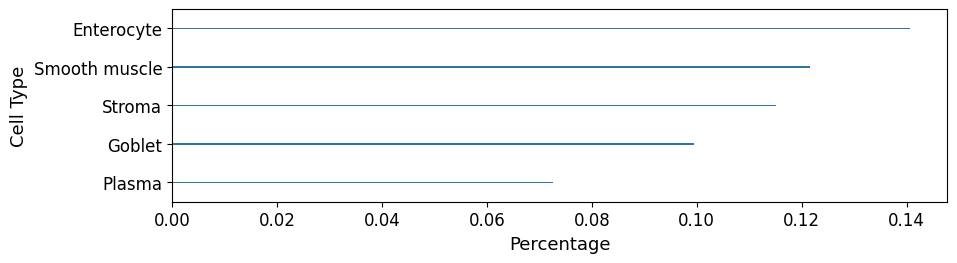

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, caecum, sc_transcriptomics, celltypist
large intestine, Female, caecum, sc_transcriptomics, celltypist


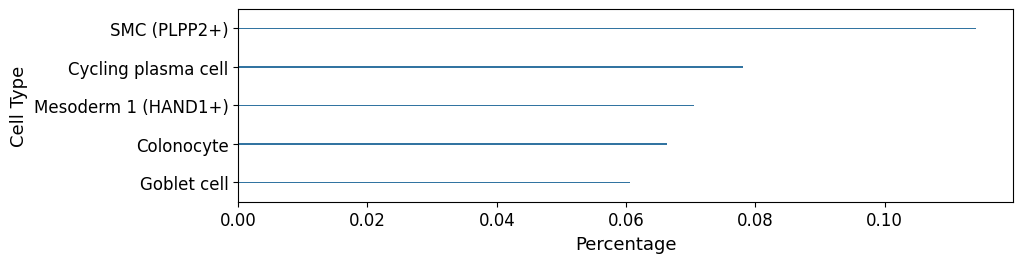

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, descending colon, sc_proteomics, sc_proteomics
large intestine, Female, descending colon, sc_proteomics, sc_proteomics


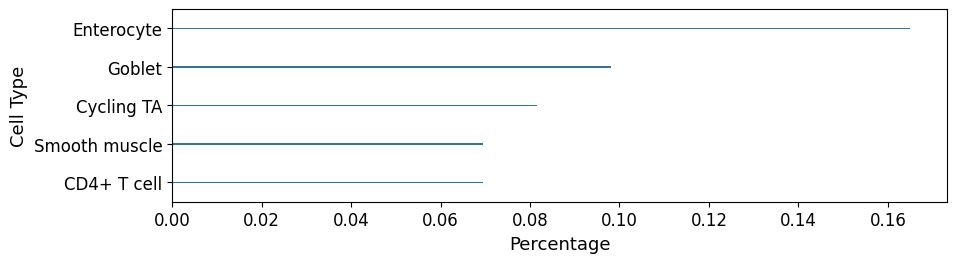

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, descending colon, sc_transcriptomics, celltypist
large intestine, Female, descending colon, sc_transcriptomics, celltypist


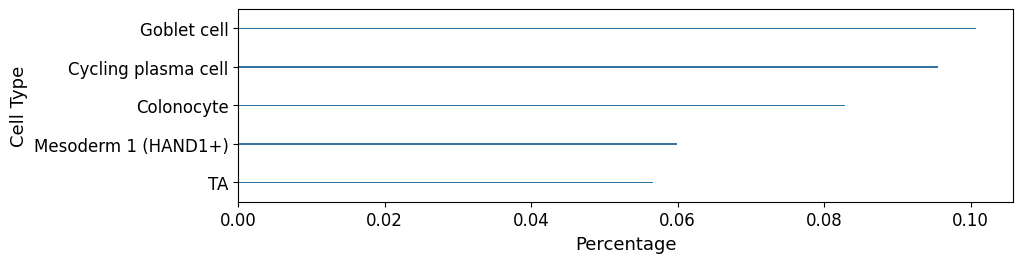

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, sigmoid colon, sc_proteomics, sc_proteomics
large intestine, Female, sigmoid colon, sc_proteomics, sc_proteomics


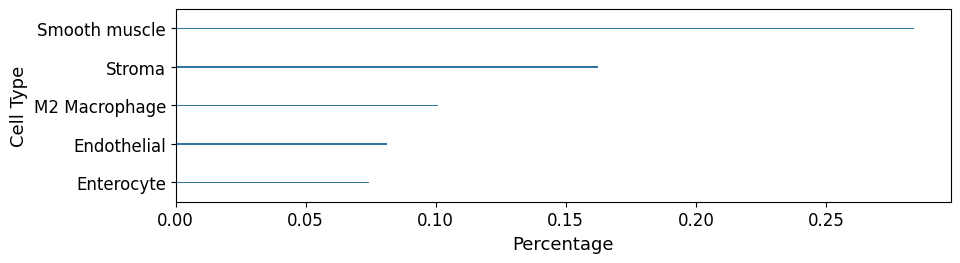

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, sigmoid colon, sc_transcriptomics, celltypist
large intestine, Female, sigmoid colon, sc_transcriptomics, celltypist


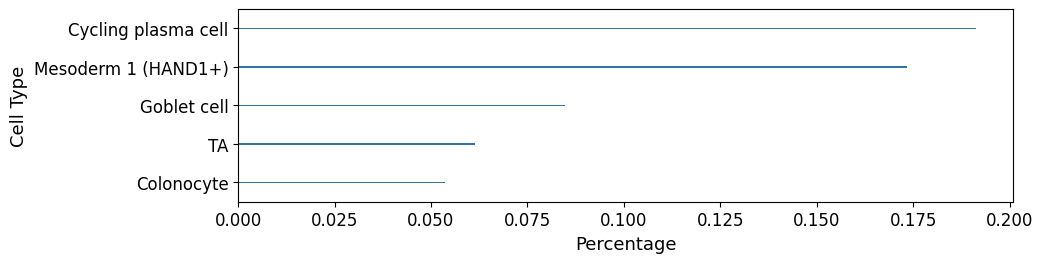

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, transverse colon, sc_proteomics, sc_proteomics
large intestine, Female, transverse colon, sc_proteomics, sc_proteomics


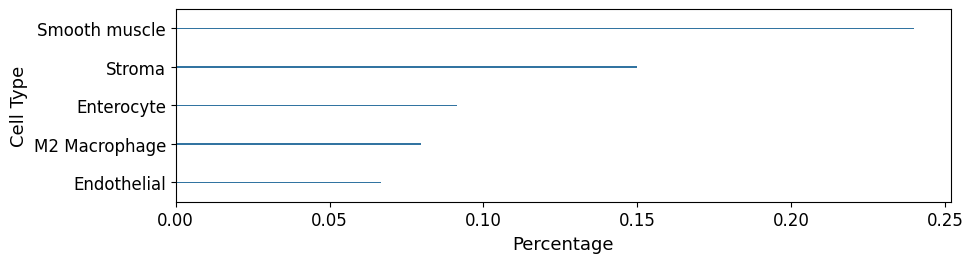

<Figure size 1000x200 with 0 Axes>

values: large intestine, Female, transverse colon, sc_transcriptomics, celltypist
large intestine, Female, transverse colon, sc_transcriptomics, celltypist


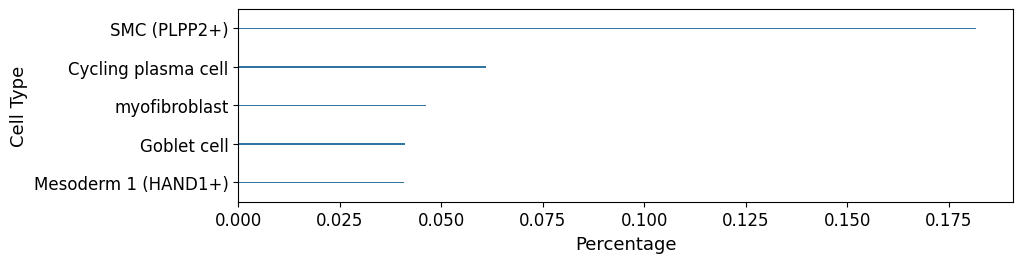

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, ascending colon, sc_proteomics, sc_proteomics
large intestine, Male, ascending colon, sc_proteomics, sc_proteomics


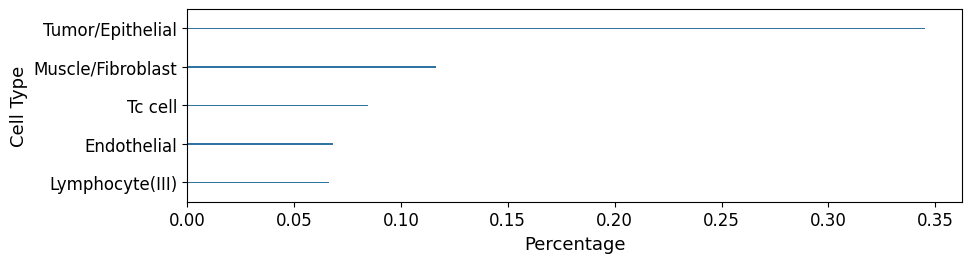

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, ascending colon, sc_transcriptomics, celltypist
large intestine, Male, ascending colon, sc_transcriptomics, celltypist


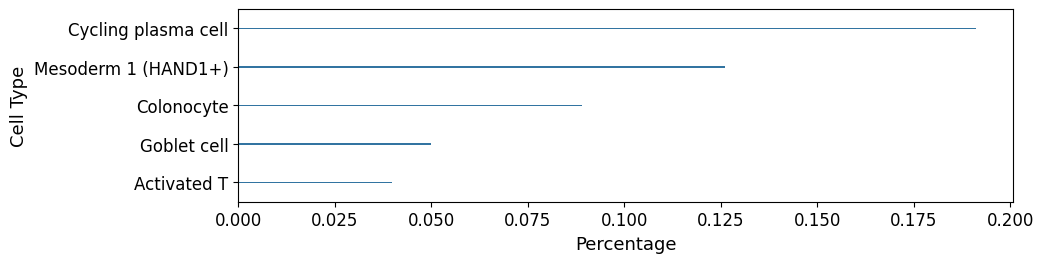

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, caecum, sc_proteomics, sc_proteomics
large intestine, Male, caecum, sc_proteomics, sc_proteomics


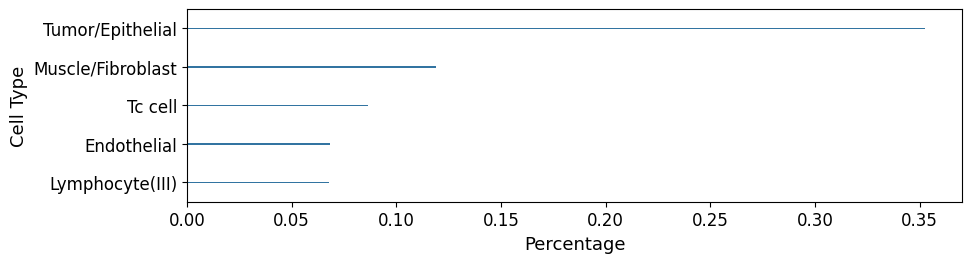

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, descending colon, sc_proteomics, sc_proteomics
large intestine, Male, descending colon, sc_proteomics, sc_proteomics


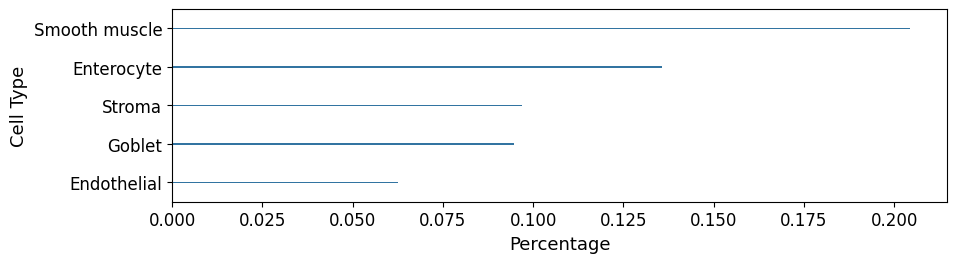

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, descending colon, sc_transcriptomics, celltypist
large intestine, Male, descending colon, sc_transcriptomics, celltypist


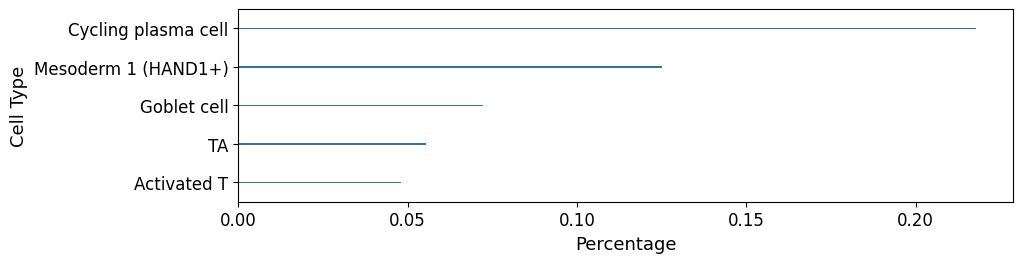

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, sigmoid colon, sc_proteomics, sc_proteomics
large intestine, Male, sigmoid colon, sc_proteomics, sc_proteomics


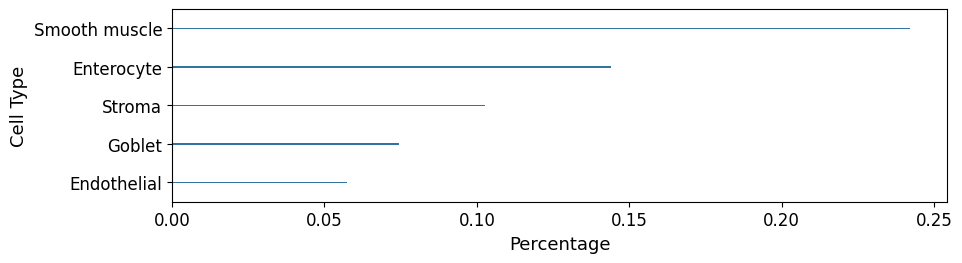

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, sigmoid colon, sc_transcriptomics, celltypist
large intestine, Male, sigmoid colon, sc_transcriptomics, celltypist


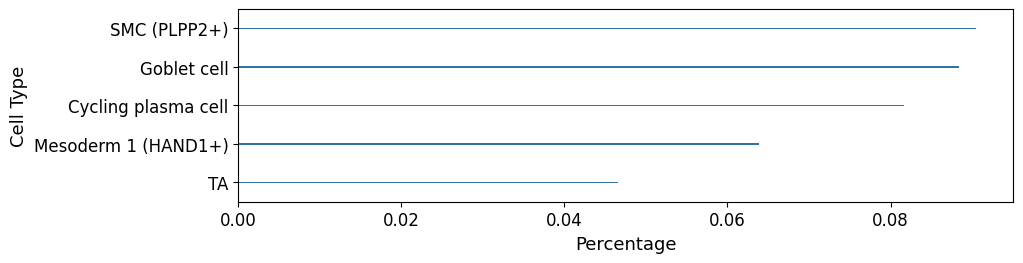

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, transverse colon, sc_proteomics, sc_proteomics
large intestine, Male, transverse colon, sc_proteomics, sc_proteomics


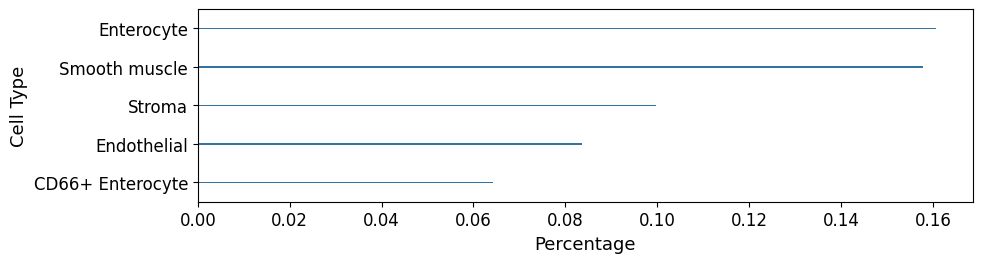

<Figure size 1000x200 with 0 Axes>

values: large intestine, Male, transverse colon, sc_transcriptomics, celltypist
large intestine, Male, transverse colon, sc_transcriptomics, celltypist


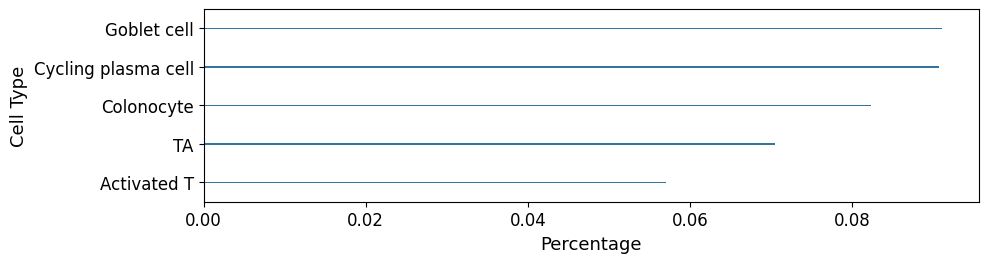

<Figure size 1000x200 with 0 Axes>

values: liver, Male, capsule of the liver, sc_transcriptomics, celltypist
liver, Male, capsule of the liver, sc_transcriptomics, celltypist


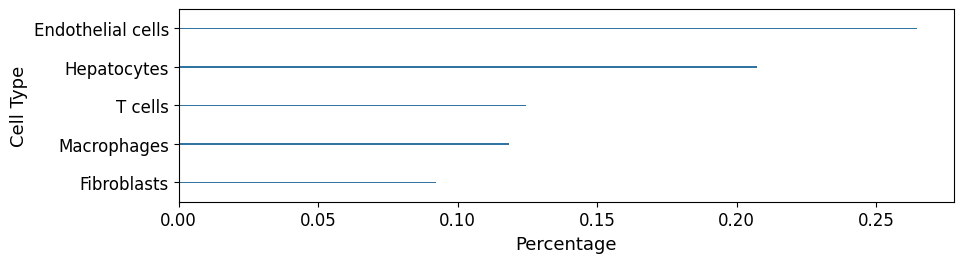

<Figure size 1000x200 with 0 Axes>

values: liver, Male, diaphragmatic surface of liver, sc_transcriptomics, celltypist
liver, Male, diaphragmatic surface of liver, sc_transcriptomics, celltypist


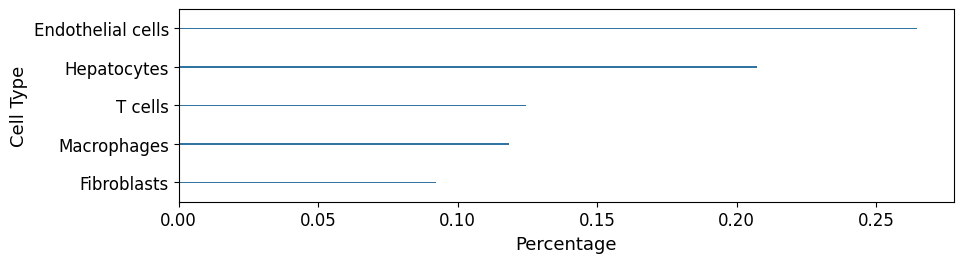

<Figure size 1000x200 with 0 Axes>

values: liver, Male, gastric impression of liver, sc_transcriptomics, celltypist
liver, Male, gastric impression of liver, sc_transcriptomics, celltypist


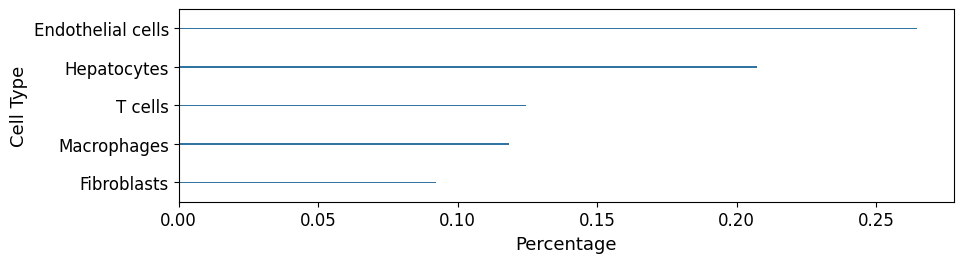

<Figure size 1000x200 with 0 Axes>

values: lung, Female, Cartilage of segmental bronchus, sc_transcriptomics, azimuth
lung, Female, Cartilage of segmental bronchus, sc_transcriptomics, azimuth


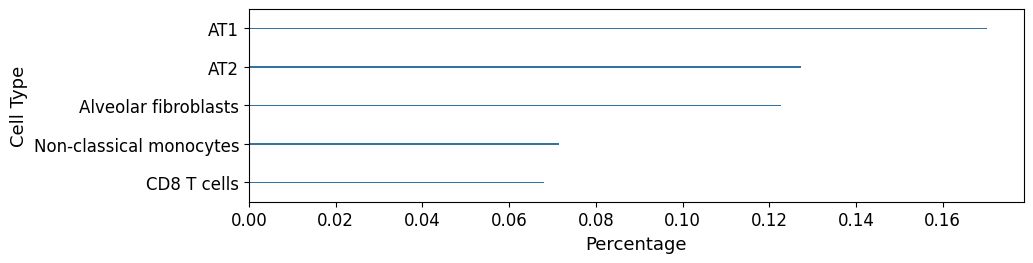

<Figure size 1000x200 with 0 Axes>

values: lung, Female, Lateral segmental bronchus, sc_transcriptomics, azimuth
lung, Female, Lateral segmental bronchus, sc_transcriptomics, azimuth


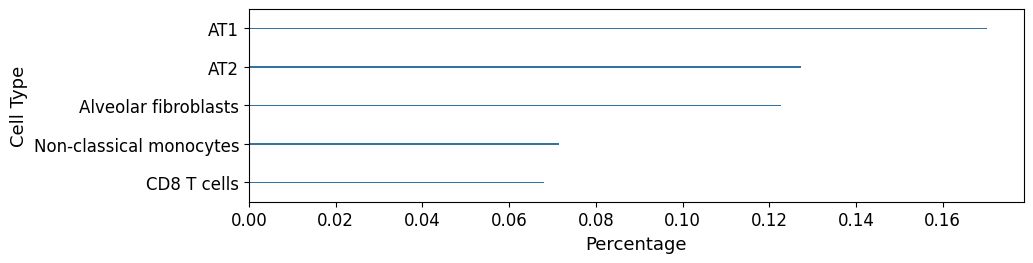

<Figure size 1000x200 with 0 Axes>

values: lung, Female, Right Posterior Basal Bronchopulmonary Segment, sc_proteomics, sc_proteomics
lung, Female, Right Posterior Basal Bronchopulmonary Segment, sc_proteomics, sc_proteomics


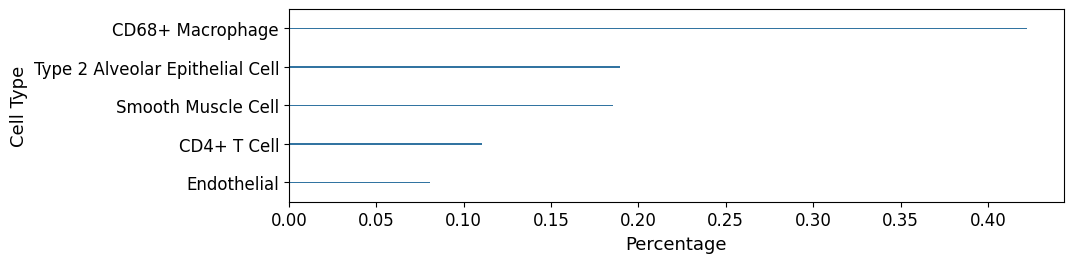

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Lateral segmental bronchus, sc_transcriptomics, azimuth
lung, Male, Lateral segmental bronchus, sc_transcriptomics, azimuth


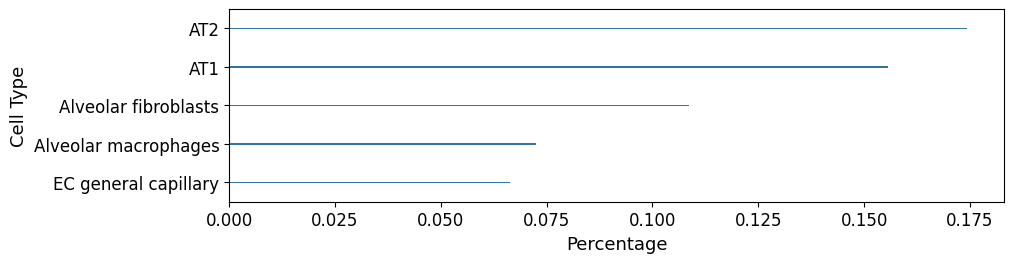

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left Anterior Bronchopulmonary Segment, sc_transcriptomics, azimuth
lung, Male, Left Anterior Bronchopulmonary Segment, sc_transcriptomics, azimuth


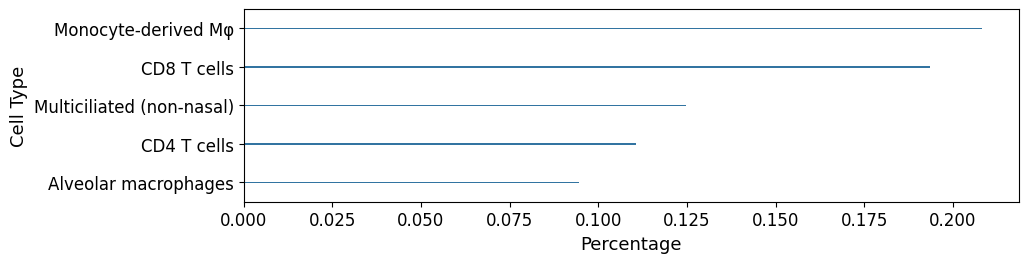

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left Medial Basal Bronchopulmonary Segment, sc_transcriptomics, azimuth
lung, Male, Left Medial Basal Bronchopulmonary Segment, sc_transcriptomics, azimuth


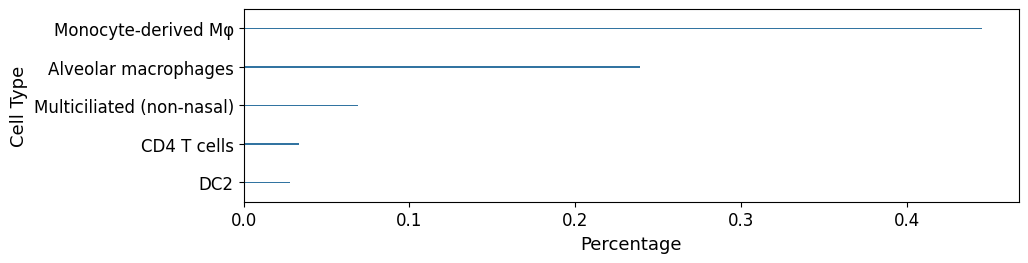

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left anterior segmental bronchus, sc_transcriptomics, azimuth
lung, Male, Left anterior segmental bronchus, sc_transcriptomics, azimuth


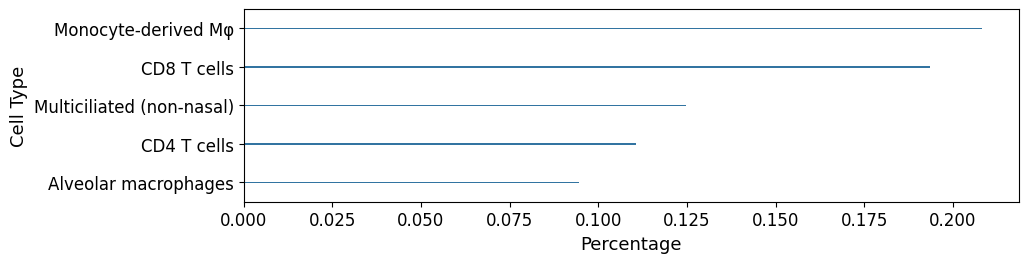

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left apical bronchopulmonary segment, sc_transcriptomics, azimuth
lung, Male, Left apical bronchopulmonary segment, sc_transcriptomics, azimuth


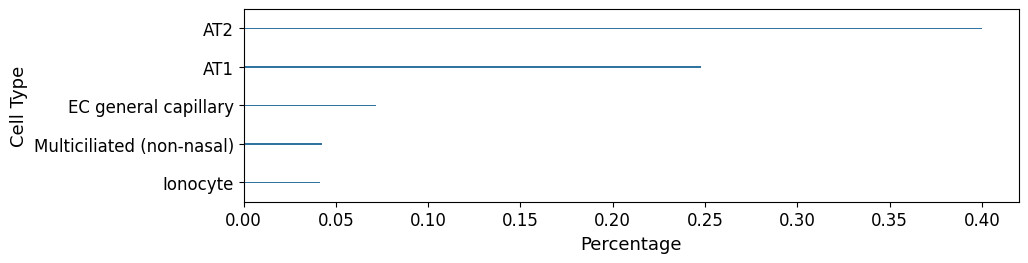

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left apical segmental bronchus, sc_transcriptomics, azimuth
lung, Male, Left apical segmental bronchus, sc_transcriptomics, azimuth


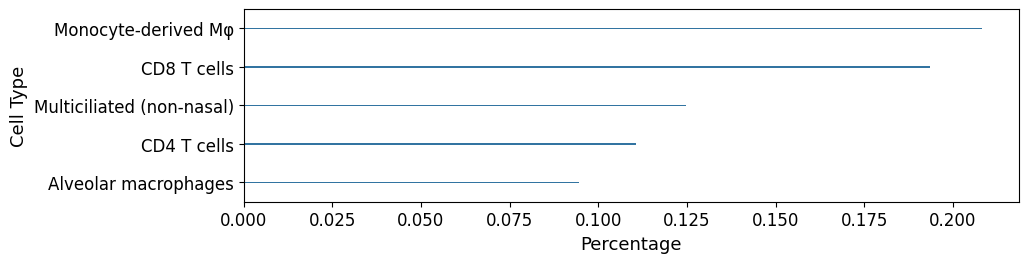

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left lateral basal segmental bronchus, sc_transcriptomics, azimuth
lung, Male, Left lateral basal segmental bronchus, sc_transcriptomics, azimuth


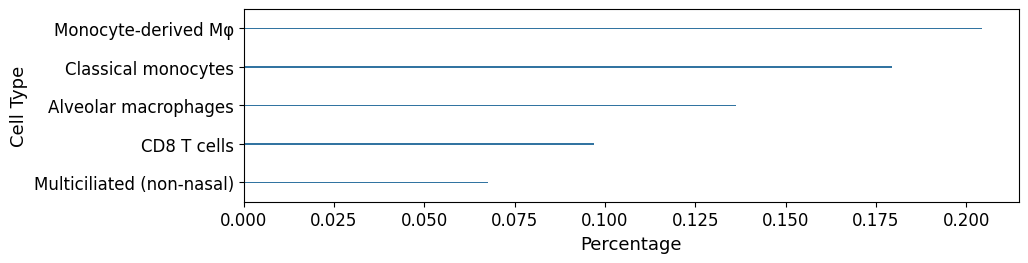

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left medial basal segmental bronchus, sc_transcriptomics, azimuth
lung, Male, Left medial basal segmental bronchus, sc_transcriptomics, azimuth


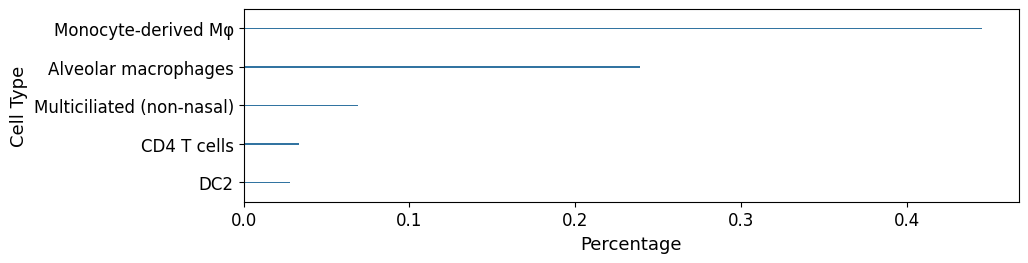

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left posterior basal segmental bronchus, sc_proteomics, sc_proteomics
lung, Male, Left posterior basal segmental bronchus, sc_proteomics, sc_proteomics


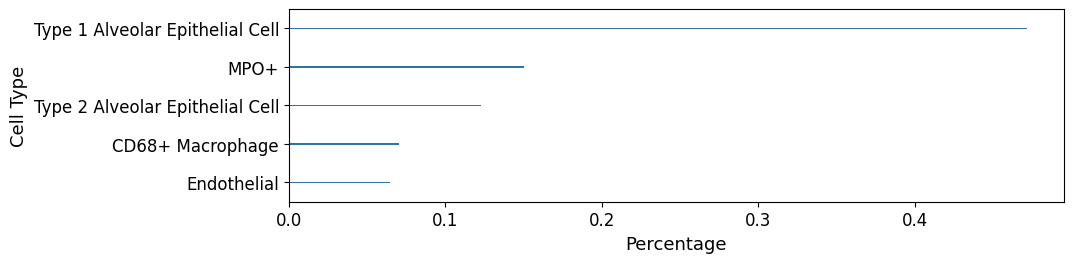

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left posterior basal segmental bronchus, sc_transcriptomics, azimuth
lung, Male, Left posterior basal segmental bronchus, sc_transcriptomics, azimuth


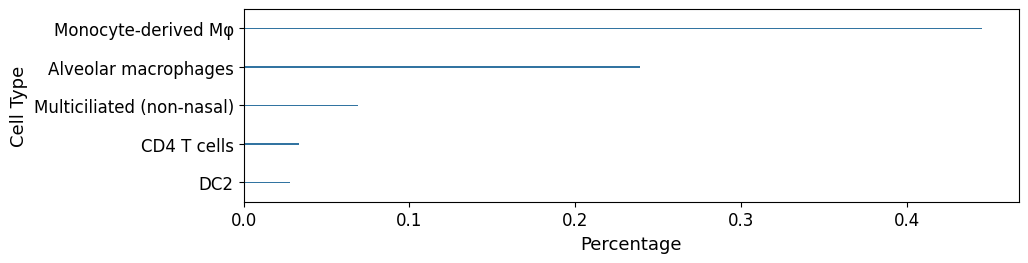

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Left posterior bronchopulmonary segment, sc_transcriptomics, azimuth
lung, Male, Left posterior bronchopulmonary segment, sc_transcriptomics, azimuth


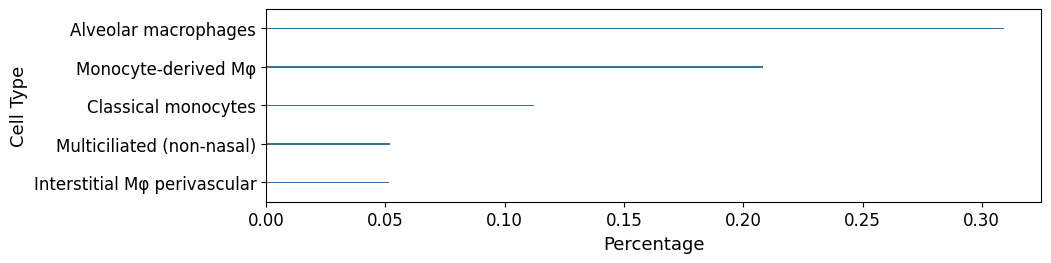

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Right Anterior Bronchopulmonary Segment, sc_transcriptomics, azimuth
lung, Male, Right Anterior Bronchopulmonary Segment, sc_transcriptomics, azimuth


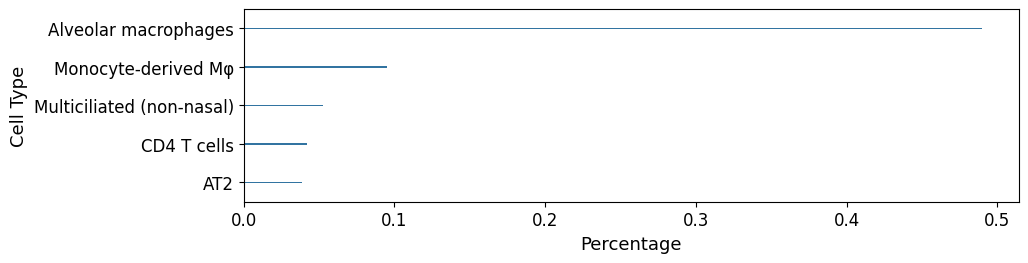

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Right Lateral Bronchopulmonary Segment, sc_transcriptomics, azimuth
lung, Male, Right Lateral Bronchopulmonary Segment, sc_transcriptomics, azimuth


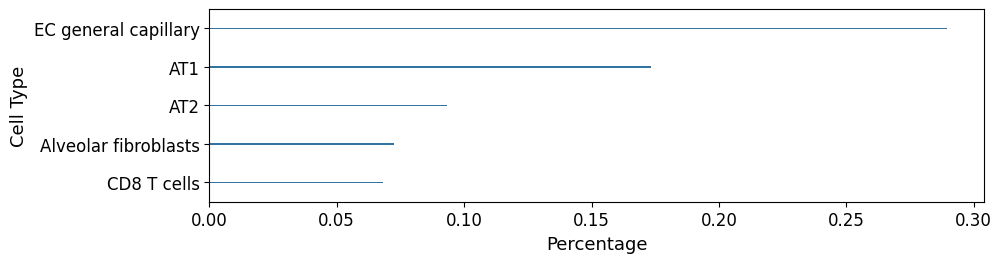

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Right Medial Bronchopulmonary Segment, sc_transcriptomics, azimuth
lung, Male, Right Medial Bronchopulmonary Segment, sc_transcriptomics, azimuth


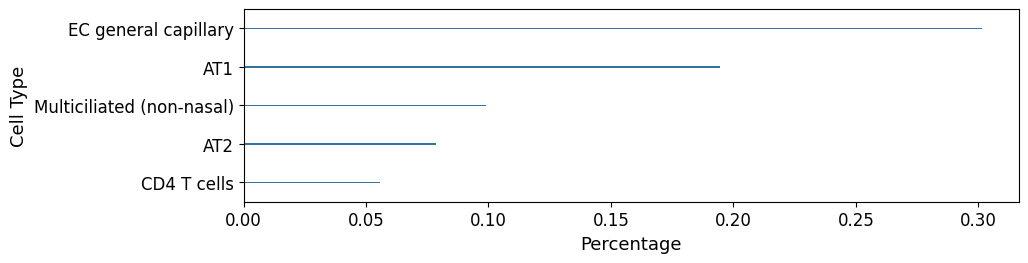

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Right Posterior Bronchopulmonary Segment, sc_transcriptomics, azimuth
lung, Male, Right Posterior Bronchopulmonary Segment, sc_transcriptomics, azimuth


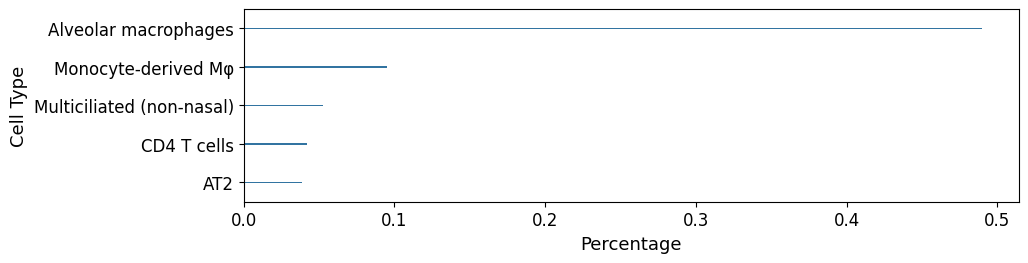

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Right anterior basal bronchopulmonary segment, sc_transcriptomics, azimuth
lung, Male, Right anterior basal bronchopulmonary segment, sc_transcriptomics, azimuth


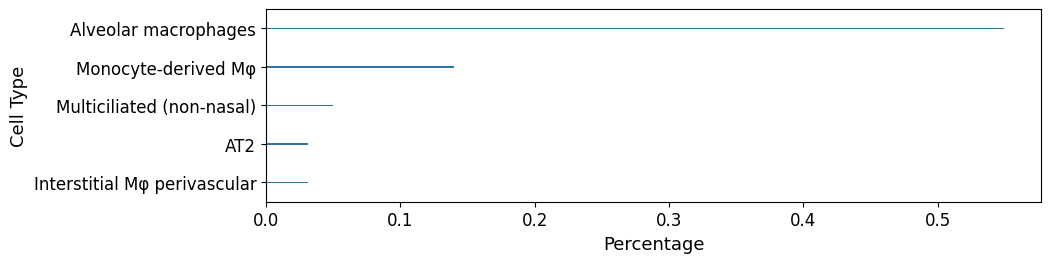

<Figure size 1000x200 with 0 Axes>

values: lung, Male, Right superior segmental bronchus, sc_transcriptomics, azimuth
lung, Male, Right superior segmental bronchus, sc_transcriptomics, azimuth


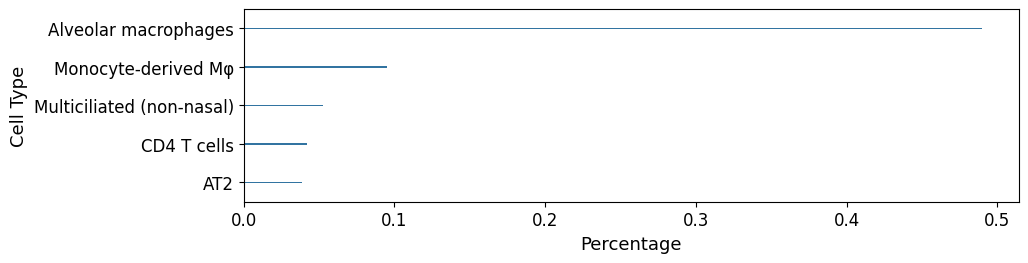

<Figure size 1000x200 with 0 Axes>

values: lung, Male, left Lateral Basal Bronchopulmonary Segment, sc_transcriptomics, azimuth
lung, Male, left Lateral Basal Bronchopulmonary Segment, sc_transcriptomics, azimuth


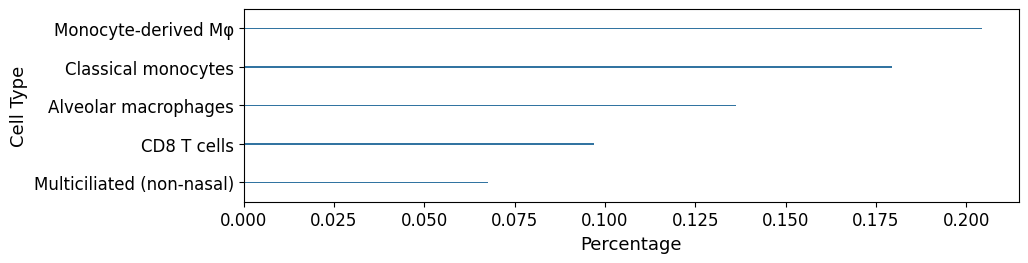

<Figure size 1000x200 with 0 Axes>

values: lung, Male, left anterior basal bronchopulmonary segment, sc_transcriptomics, azimuth
lung, Male, left anterior basal bronchopulmonary segment, sc_transcriptomics, azimuth


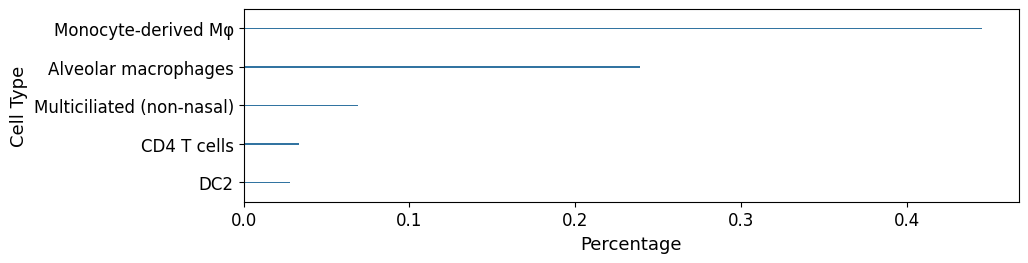

<Figure size 1000x200 with 0 Axes>

values: prostate, Male, central zone of prostate, sc_transcriptomics, popv
prostate, Male, central zone of prostate, sc_transcriptomics, popv


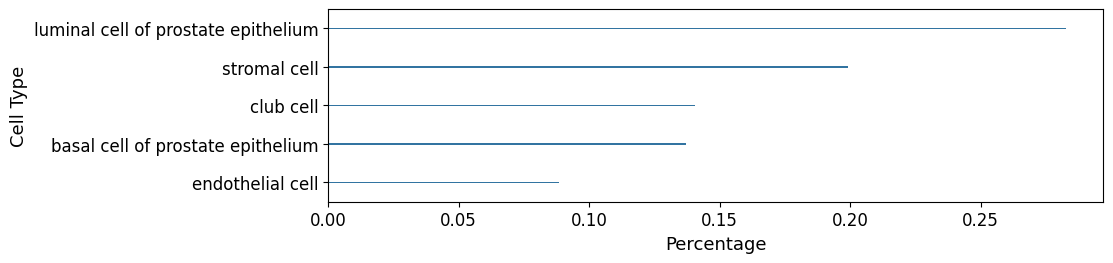

<Figure size 1000x200 with 0 Axes>

values: prostate, Male, peripheral zone of prostate, sc_transcriptomics, popv
prostate, Male, peripheral zone of prostate, sc_transcriptomics, popv


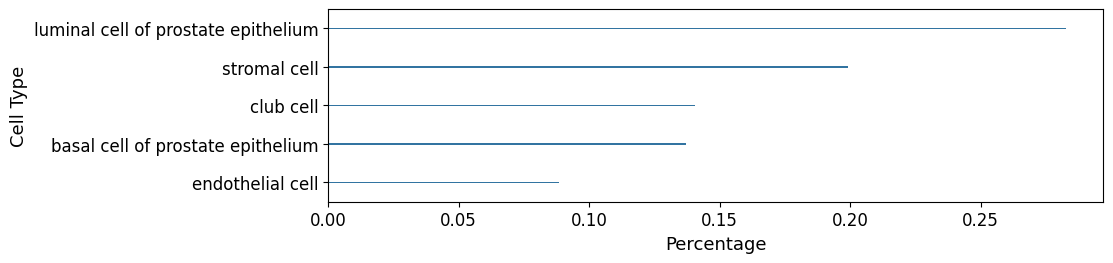

<Figure size 1000x200 with 0 Axes>

values: skin, Female, skin, sc_proteomics, sc_proteomics
skin, Female, skin, sc_proteomics, sc_proteomics


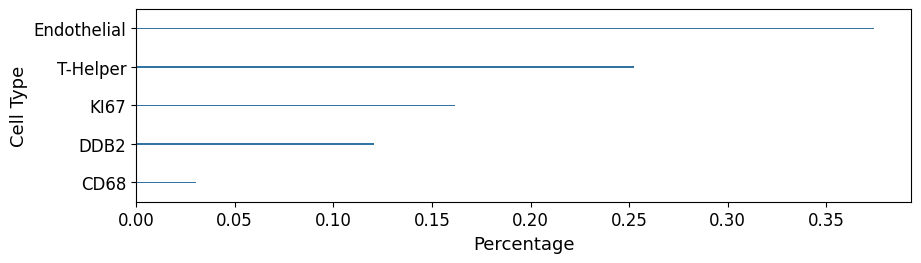

<Figure size 1000x200 with 0 Axes>

values: skin, Male, skin, sc_proteomics, sc_proteomics
skin, Male, skin, sc_proteomics, sc_proteomics


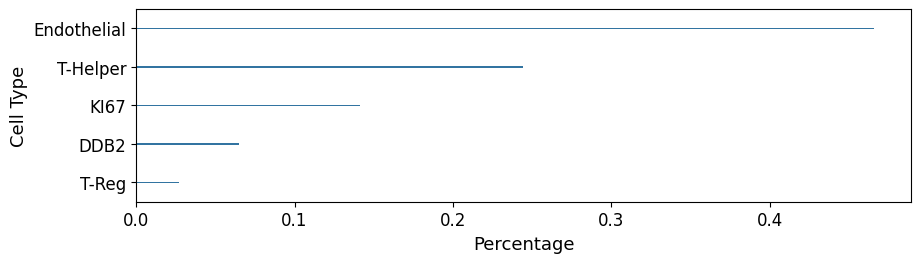

<Figure size 1000x200 with 0 Axes>

values: skin, Male, skin, sc_transcriptomics, celltypist
skin, Male, skin, sc_transcriptomics, celltypist


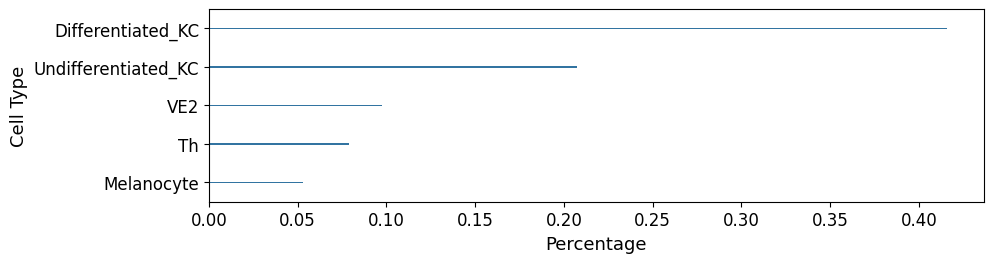

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, ascending part of duodenum, sc_proteomics, sc_proteomics
small intestine, Female, ascending part of duodenum, sc_proteomics, sc_proteomics


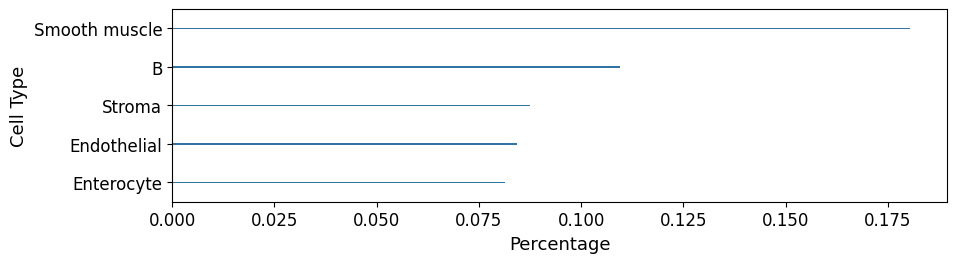

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, ascending part of duodenum, sc_transcriptomics, celltypist
small intestine, Female, ascending part of duodenum, sc_transcriptomics, celltypist


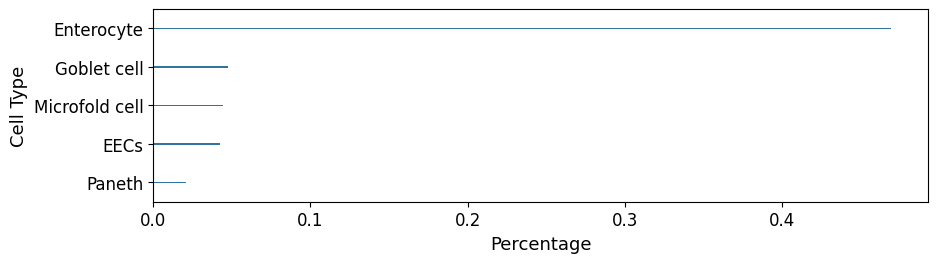

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, descending part of duodenum, sc_proteomics, sc_proteomics
small intestine, Female, descending part of duodenum, sc_proteomics, sc_proteomics


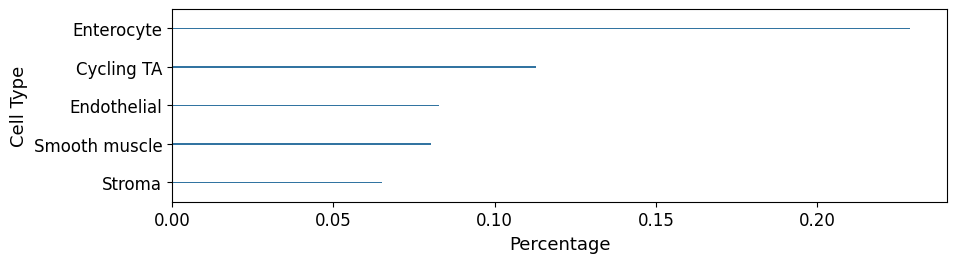

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, descending part of duodenum, sc_transcriptomics, celltypist
small intestine, Female, descending part of duodenum, sc_transcriptomics, celltypist


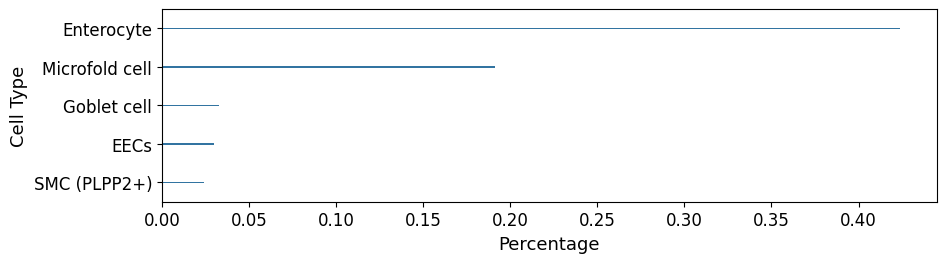

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, distal part of ileum, sc_proteomics, sc_proteomics
small intestine, Female, distal part of ileum, sc_proteomics, sc_proteomics


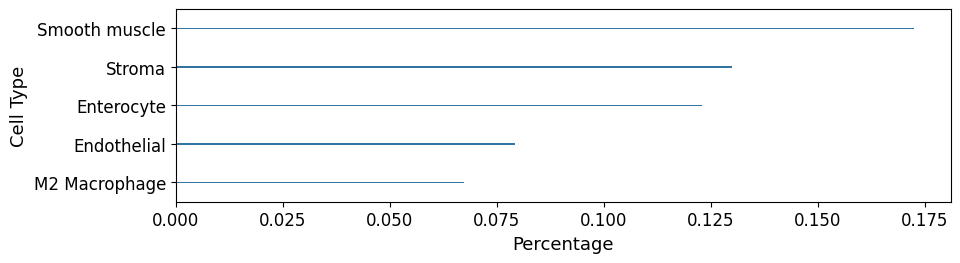

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, distal part of ileum, sc_transcriptomics, celltypist
small intestine, Female, distal part of ileum, sc_transcriptomics, celltypist


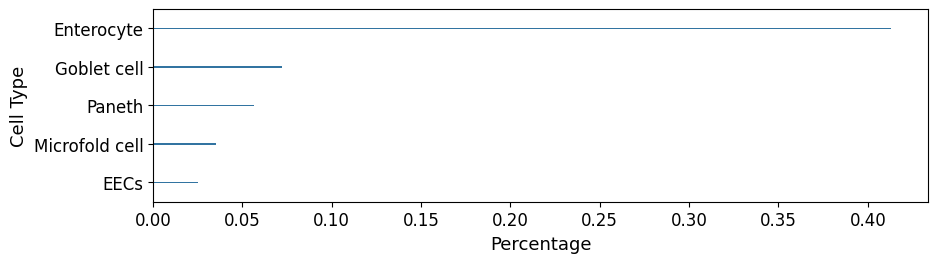

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, horizontal part of duodenum, sc_proteomics, sc_proteomics
small intestine, Female, horizontal part of duodenum, sc_proteomics, sc_proteomics


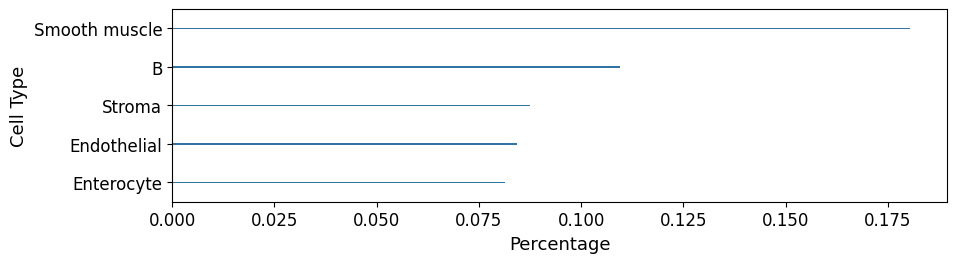

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, horizontal part of duodenum, sc_transcriptomics, celltypist
small intestine, Female, horizontal part of duodenum, sc_transcriptomics, celltypist


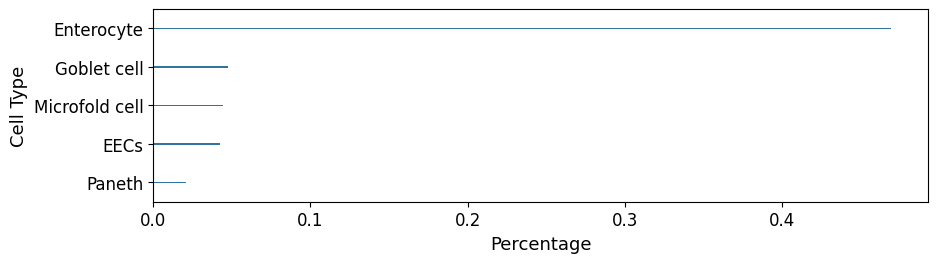

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, ileum, sc_proteomics, sc_proteomics
small intestine, Female, ileum, sc_proteomics, sc_proteomics


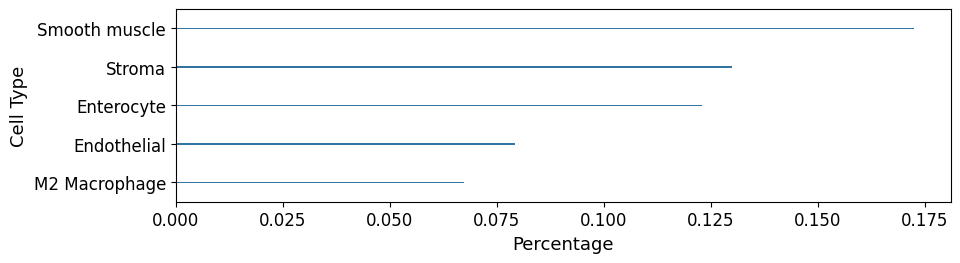

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, ileum, sc_transcriptomics, celltypist
small intestine, Female, ileum, sc_transcriptomics, celltypist


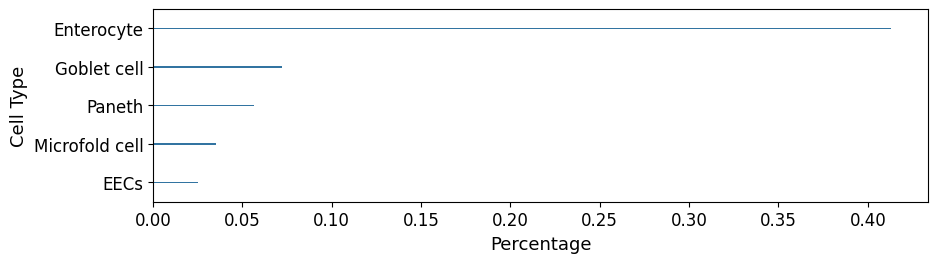

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, jejunum, sc_proteomics, sc_proteomics
small intestine, Female, jejunum, sc_proteomics, sc_proteomics


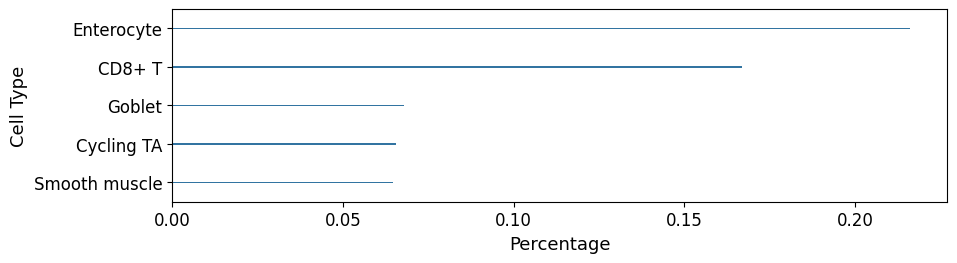

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, jejunum, sc_transcriptomics, celltypist
small intestine, Female, jejunum, sc_transcriptomics, celltypist


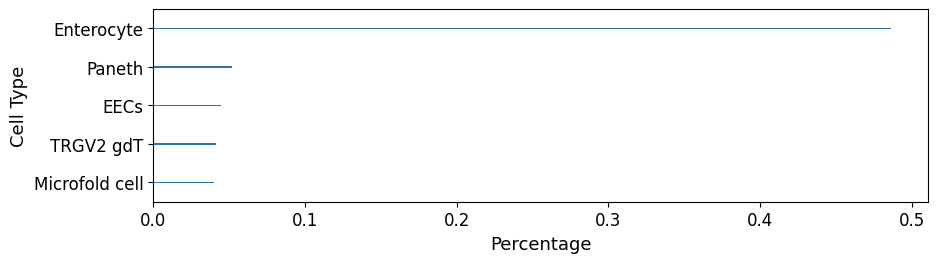

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, superior part of duodenum, sc_proteomics, sc_proteomics
small intestine, Female, superior part of duodenum, sc_proteomics, sc_proteomics


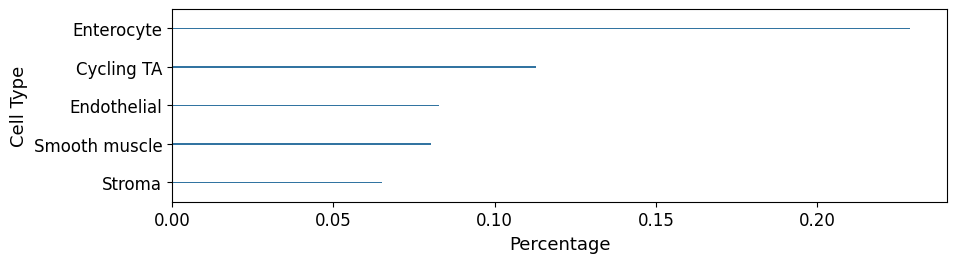

<Figure size 1000x200 with 0 Axes>

values: small intestine, Female, superior part of duodenum, sc_transcriptomics, celltypist
small intestine, Female, superior part of duodenum, sc_transcriptomics, celltypist


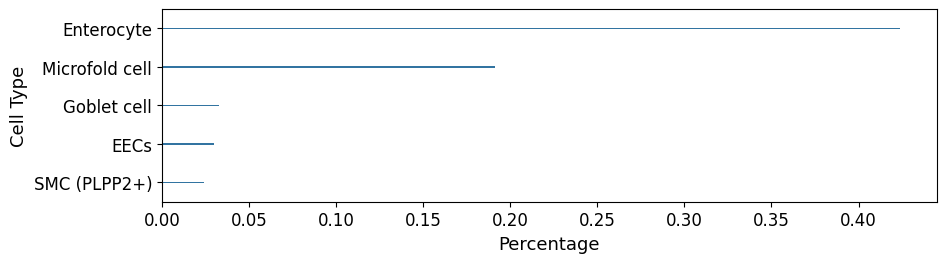

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, ascending part of duodenum, sc_proteomics, sc_proteomics
small intestine, Male, ascending part of duodenum, sc_proteomics, sc_proteomics


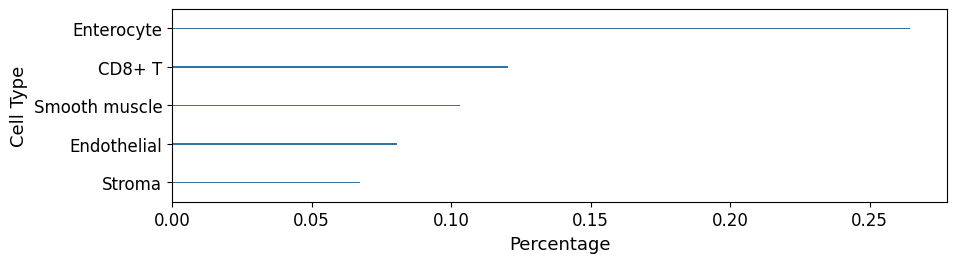

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, ascending part of duodenum, sc_transcriptomics, celltypist
small intestine, Male, ascending part of duodenum, sc_transcriptomics, celltypist


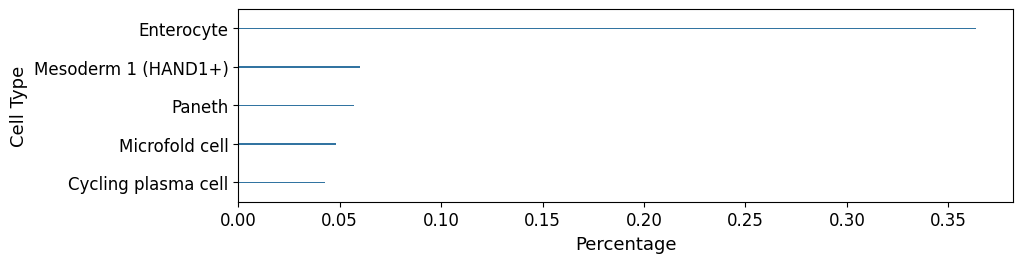

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, descending part of duodenum, sc_proteomics, sc_proteomics
small intestine, Male, descending part of duodenum, sc_proteomics, sc_proteomics


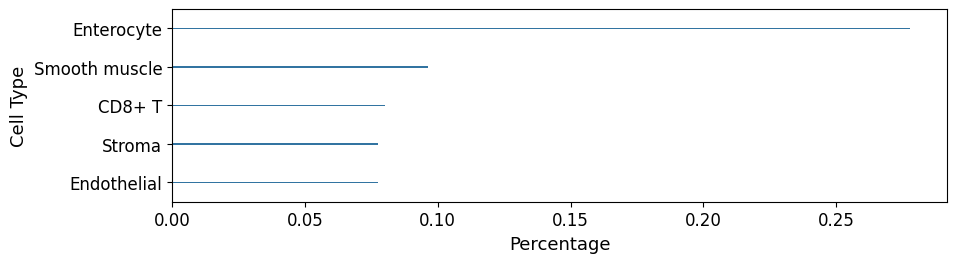

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, descending part of duodenum, sc_transcriptomics, celltypist
small intestine, Male, descending part of duodenum, sc_transcriptomics, celltypist


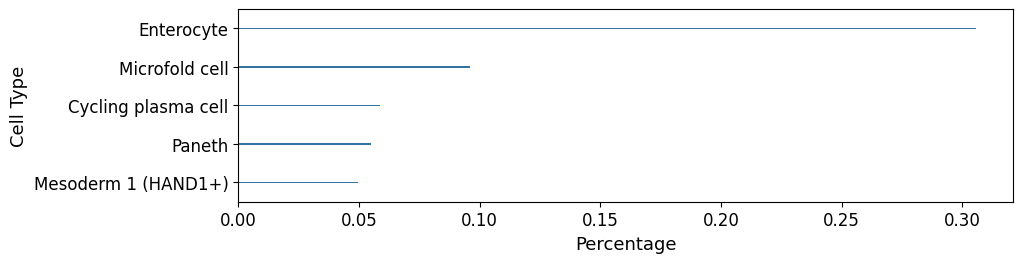

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, distal part of ileum, sc_proteomics, sc_proteomics
small intestine, Male, distal part of ileum, sc_proteomics, sc_proteomics


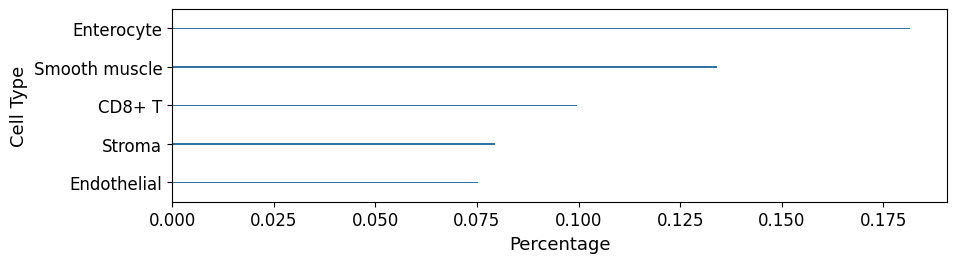

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, distal part of ileum, sc_transcriptomics, celltypist
small intestine, Male, distal part of ileum, sc_transcriptomics, celltypist


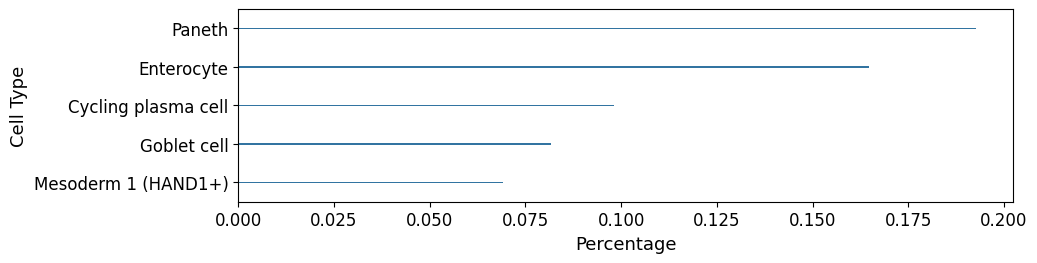

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, horizontal part of duodenum, sc_proteomics, sc_proteomics
small intestine, Male, horizontal part of duodenum, sc_proteomics, sc_proteomics


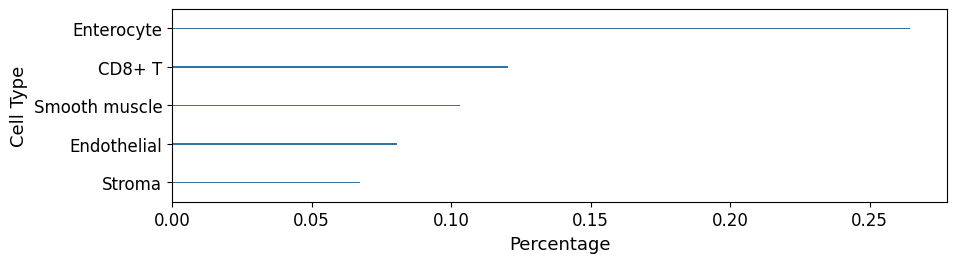

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, horizontal part of duodenum, sc_transcriptomics, celltypist
small intestine, Male, horizontal part of duodenum, sc_transcriptomics, celltypist


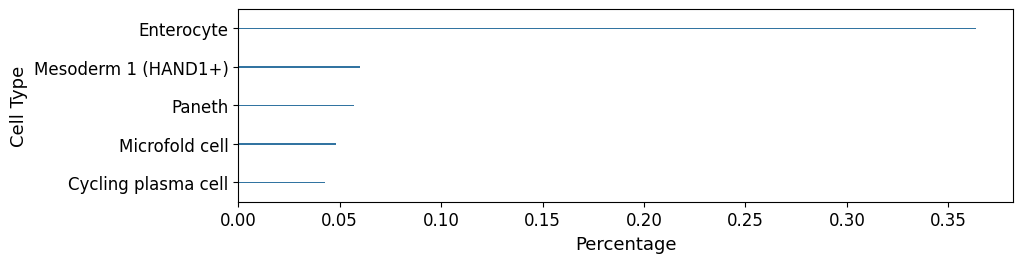

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, jejunum, sc_proteomics, sc_proteomics
small intestine, Male, jejunum, sc_proteomics, sc_proteomics


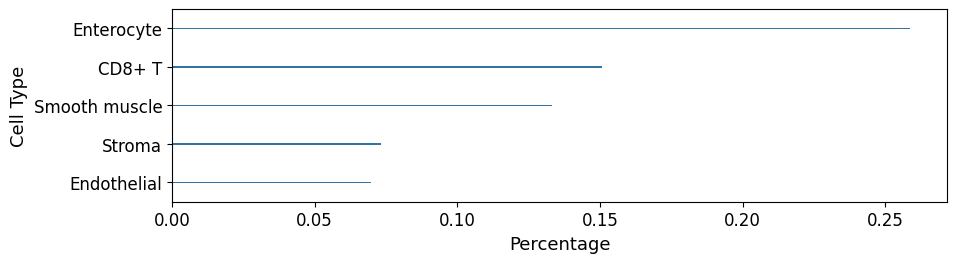

<Figure size 1000x200 with 0 Axes>

values: small intestine, Male, jejunum, sc_transcriptomics, celltypist
small intestine, Male, jejunum, sc_transcriptomics, celltypist


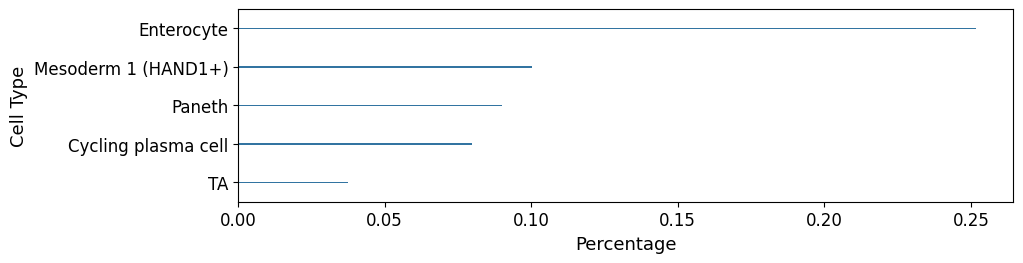

<Figure size 1000x200 with 0 Axes>

values: spleen, Female, diaphragmatic surface of spleen, sc_proteomics, sc_proteomics
spleen, Female, diaphragmatic surface of spleen, sc_proteomics, sc_proteomics


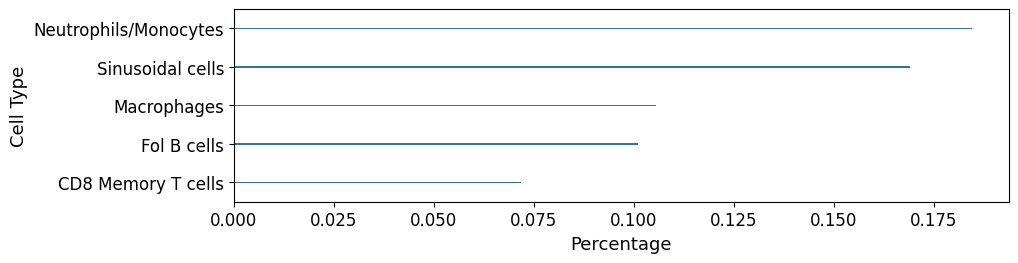

<Figure size 1000x200 with 0 Axes>

values: spleen, Female, diaphragmatic surface of spleen, sc_transcriptomics, popv
spleen, Female, diaphragmatic surface of spleen, sc_transcriptomics, popv


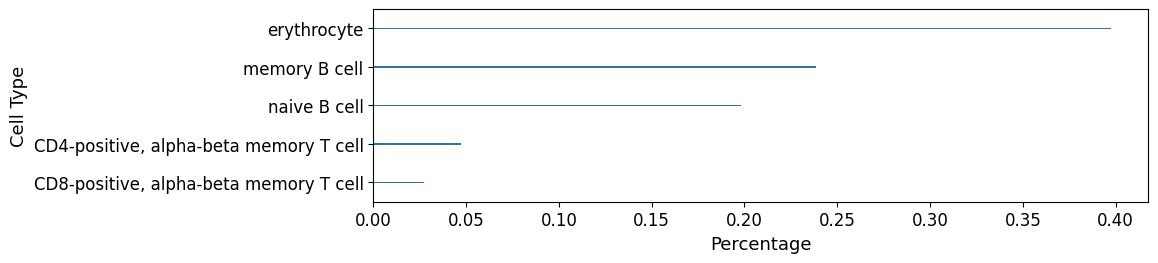

<Figure size 1000x200 with 0 Axes>

values: spleen, Female, hilum of spleen, sc_proteomics, sc_proteomics
spleen, Female, hilum of spleen, sc_proteomics, sc_proteomics


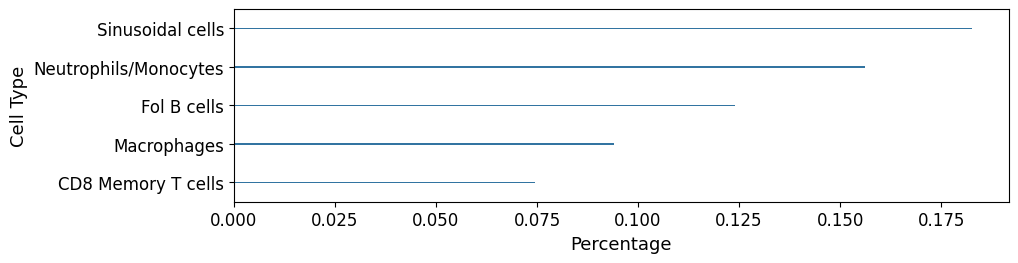

<Figure size 1000x200 with 0 Axes>

values: spleen, Female, hilum of spleen, sc_transcriptomics, popv
spleen, Female, hilum of spleen, sc_transcriptomics, popv


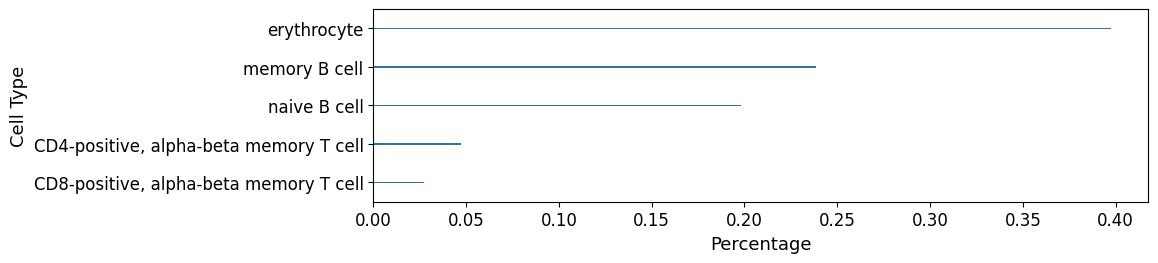

<Figure size 1000x200 with 0 Axes>

values: spleen, Male, diaphragmatic surface of spleen, sc_proteomics, sc_proteomics
spleen, Male, diaphragmatic surface of spleen, sc_proteomics, sc_proteomics


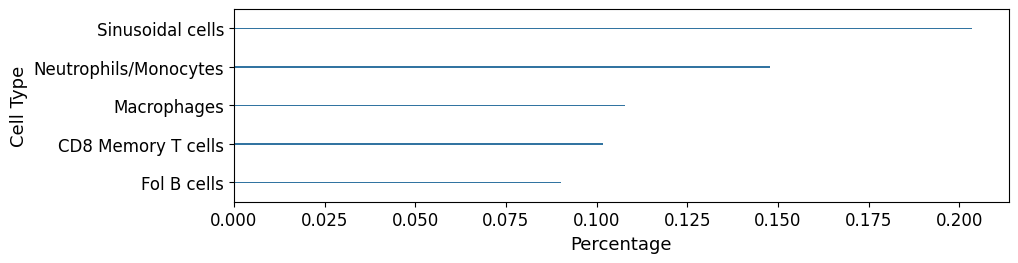

<Figure size 1000x200 with 0 Axes>

values: spleen, Male, diaphragmatic surface of spleen, sc_transcriptomics, popv
spleen, Male, diaphragmatic surface of spleen, sc_transcriptomics, popv


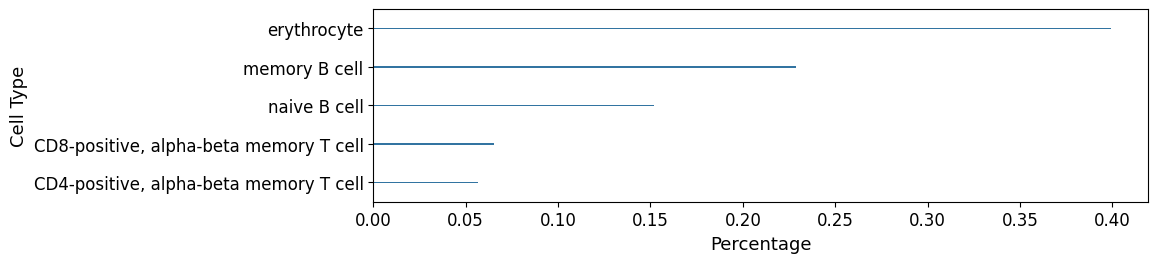

<Figure size 1000x200 with 0 Axes>

values: spleen, Male, hilum of spleen, sc_proteomics, sc_proteomics
spleen, Male, hilum of spleen, sc_proteomics, sc_proteomics


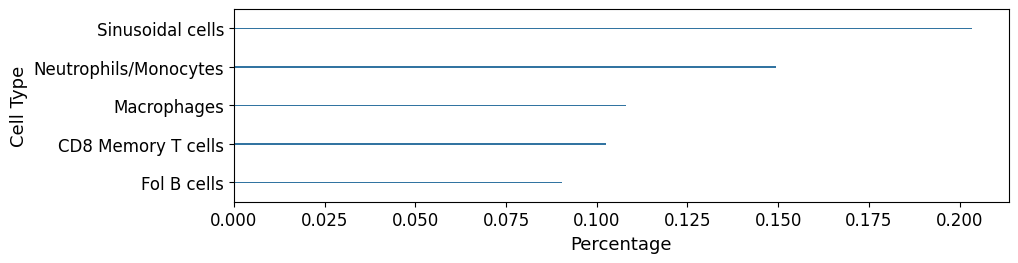

<Figure size 1000x200 with 0 Axes>

values: spleen, Male, hilum of spleen, sc_transcriptomics, popv
spleen, Male, hilum of spleen, sc_transcriptomics, popv


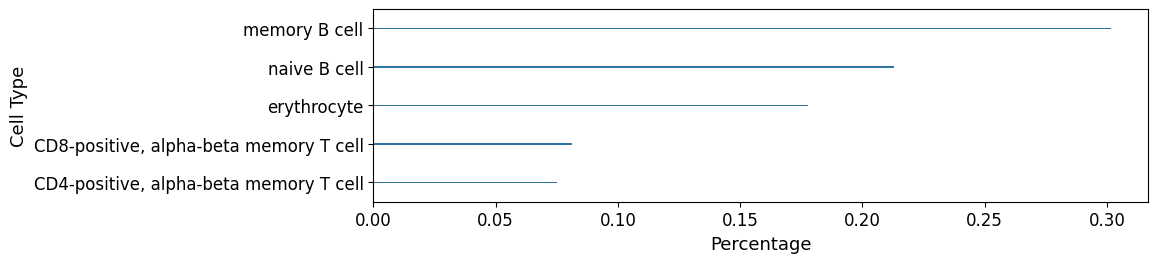

<Figure size 1000x200 with 0 Axes>

values: spleen, Male, renal surface of spleen, sc_proteomics, sc_proteomics
spleen, Male, renal surface of spleen, sc_proteomics, sc_proteomics


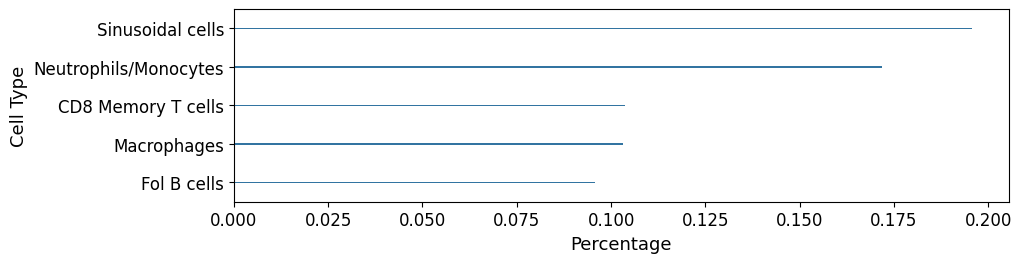

<Figure size 1000x200 with 0 Axes>

values: urinary bladder, Female, fundus of urinary bladder, sc_transcriptomics, popv
urinary bladder, Female, fundus of urinary bladder, sc_transcriptomics, popv


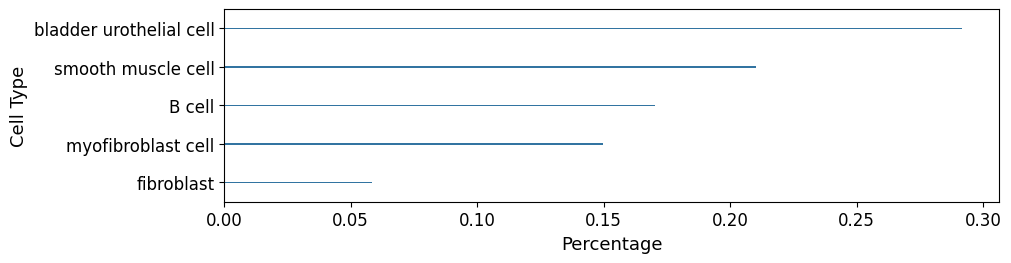

<Figure size 1000x200 with 0 Axes>

values: urinary bladder, Male, fundus of urinary bladder, sc_transcriptomics, popv
urinary bladder, Male, fundus of urinary bladder, sc_transcriptomics, popv


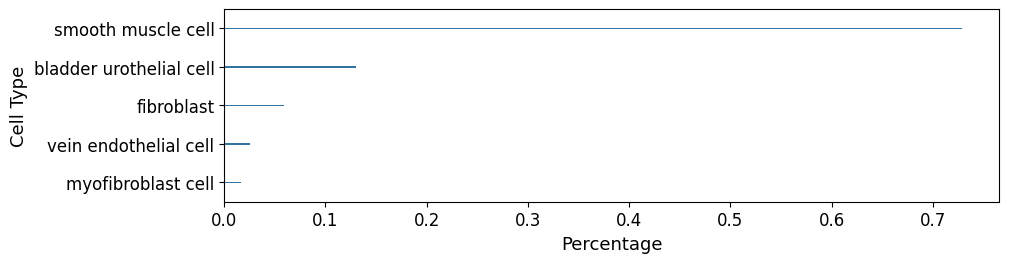

<Figure size 1000x200 with 0 Axes>

values: urinary bladder, Male, trigone of urinary bladder, sc_transcriptomics, popv
urinary bladder, Male, trigone of urinary bladder, sc_transcriptomics, popv


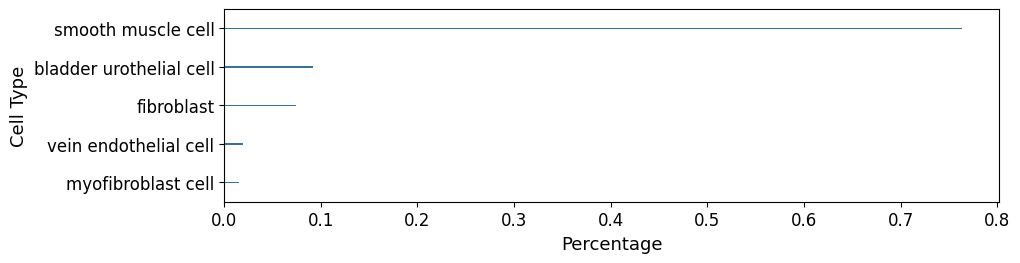

<Figure size 1000x200 with 0 Axes>

In [385]:
for index, row in unique_combinations.iterrows():
  print(
      f'values: {row['organ']}, {row['sex']}, {row['as_label']}, {row['modality']}, {row['tool']}')
  if True:
    build_grouped_bar_graph(df_filtered, row['organ'],row['sex'], row['as_label'], row['modality'], row['tool'])

## Make look-up for `as_label` to `node_name`

In [386]:
url = 'https://cdn.humanatlas.io/digital-objects/ref-organ/asct-b-3d-models-crosswalk/v1.7/assets/asct-b-3d-models-crosswalk.csv'
df_crosswalk = pd.read_csv(url, skiprows=10)
df_crosswalk

,anatomical_structure_of,source_spatial_entity,node_name,label,OntologyID,representation_of,node_type,glb file of single organs,Ref/1,Ref/1/ID
0,-,#VHFemaleOrgans,VH_F_integumentary_system,integumentary system layer,UBERON:0013754,http://purl.obolibrary.org/obo/UBERON_0013754,organizational,3d-vh-f-united,NaN,NaN
1,#VHFSkinV1.1,#VHFemaleOrgans,VH_F_skin,skin of body,UBERON:0002097,http://purl.obolibrary.org/obo/UBERON_0002097,mesh,3d-vh-f-skin,NaN,NaN
2,-,-,VH_F_mammary_gland,-,-,-,organizational,-,NaN,NaN
3,#VHFLeftMammaryGland,#VHFemaleOrgans,VH_F_mammary_gland_L,Left mammary gland,FMA:57991,http://purl.org/sig/ont/fma/fma57991,organizational,3d-vh-f-mammary-gland-l,NaN,NaN
4,#VHFLeftMammaryGland,#VHFemaleOrgans,VH_F_fat_L,Interlobar adipose tissue of left mammary gland,FMA:73166,http://purl.org/sig/ont/fma/fma73166,mesh,3d-vh-f-mammary-gland-l,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2108,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_1,lumbar vertebra 1,UBERON:0004617,http://purl.obolibrary.org/obo/UBERON_0004617,mesh,VH_M_Vertebrae,NaN,NaN
2109,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_2,lumbar vertebra 2,UBERON:0004618,http://purl.obolibrary.org/obo/UBERON_0004618,mesh,VH_M_Vertebrae,NaN,NaN
2110,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_3,lumbar vertebra 3,UBERON:0004619,http://purl.obolibrary.org/obo/UBERON_0004619,mesh,VH_M_Vertebrae,NaN,NaN
2111,#VHMVertebrae,#VHMaleOrgans,VH_M_lumbar_vertebra_4,lumbar vertebra 4,UBERON:0004620,http://purl.obolibrary.org/obo/UBERON_0004620,mesh,VH_M_Vertebrae,NaN,NaN


In [387]:
# only keep relevant rows
df_filtered

,organ,as,as_label,sex,tool,modality,cell_id,cell_label,cell_count,cell_percentage
2057,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_4030022,Medullary Fibroblast,1832.421,0.274784
2059,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000718,Inner Medullary Collecting Duct,1146.533,0.171930
2061,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000692,Fibroblast,876.037,0.131368
2063,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000597,Papillary Tip Epithelial,749.843,0.112444
2065,Left kidney,http://purl.obolibrary.org/obo/UBERON_0008716,hilum of kidney,Female,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_1000768,Connecting Tubule,315.994,0.047385
...,...,...,...,...,...,...,...,...,...,...
4237,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000814,mature NK T cell,53.168,0.001612
4238,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0002138,endothelial cell of lymphatic vessel,52.639,0.001596
4239,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000236,B cell,20.586,0.000624
4240,urinary bladder,http://purl.obolibrary.org/obo/UBERON_0001257,trigone of urinary bladder,Male,popv,sc_transcriptomics,http://purl.obolibrary.org/obo/CL_0000084,T cell,10.935,0.000332


In [390]:
# export relevant columns
subset = df_crosswalk[['label', 'node_name', 'anatomical_structure_of']]
export = subset[subset['label'].isin(df_filtered['as_label'])]
export.to_csv('output/ctBar3dAs/crosswalk.csv', index=False)